<a href="https://colab.research.google.com/github/ms624atyale/Berenstain_FamilySocial/blob/main/prototype_word2vec_polarity_subjectivity_sentiment_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ms624atyale/Berenstain_FamilySocial

word-level semantic similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Column Names: ['text', 'publish year', 'title', 'category']
Standardized Column Names: ['text', 'publish year', 'title', 'category']
Successfully loaded 8 text entries from 'text' column.
Word2Vec model training completed.

Semantically Related Word Pairs:
come - papa: Similarity = 0.5887
come - papa: Similarity = 0.5887
papa - said: Similarity = 0.5758
papa - said: Similarity = 0.5758
house - papa: Similarity = 0.5484
house - papa: Similarity = 0.5484
mama - papa: Similarity = 0.5468
mama - papa: Similarity = 0.5468
sisters - yard: Similarity = 0.5360
sisters - yard: Similarity = 0.5360
cubs - sure: Similarity = 0.5354
cubs - sure: Similarity = 0.5354
bed - said: Similarity = 0.5302
bed - said: Similarity = 0.5302
papa - sister: Similarity = 0.5290
papa - sister: Similarity = 0.5290
know - said: Similarity = 0.5235
know - said: Similarity = 0.5235
house - said: Similarity = 0.5026
house - said: Similarity = 0.5026
bear - said: Similarity = 0.5009
bear - said: Similarity = 0.5

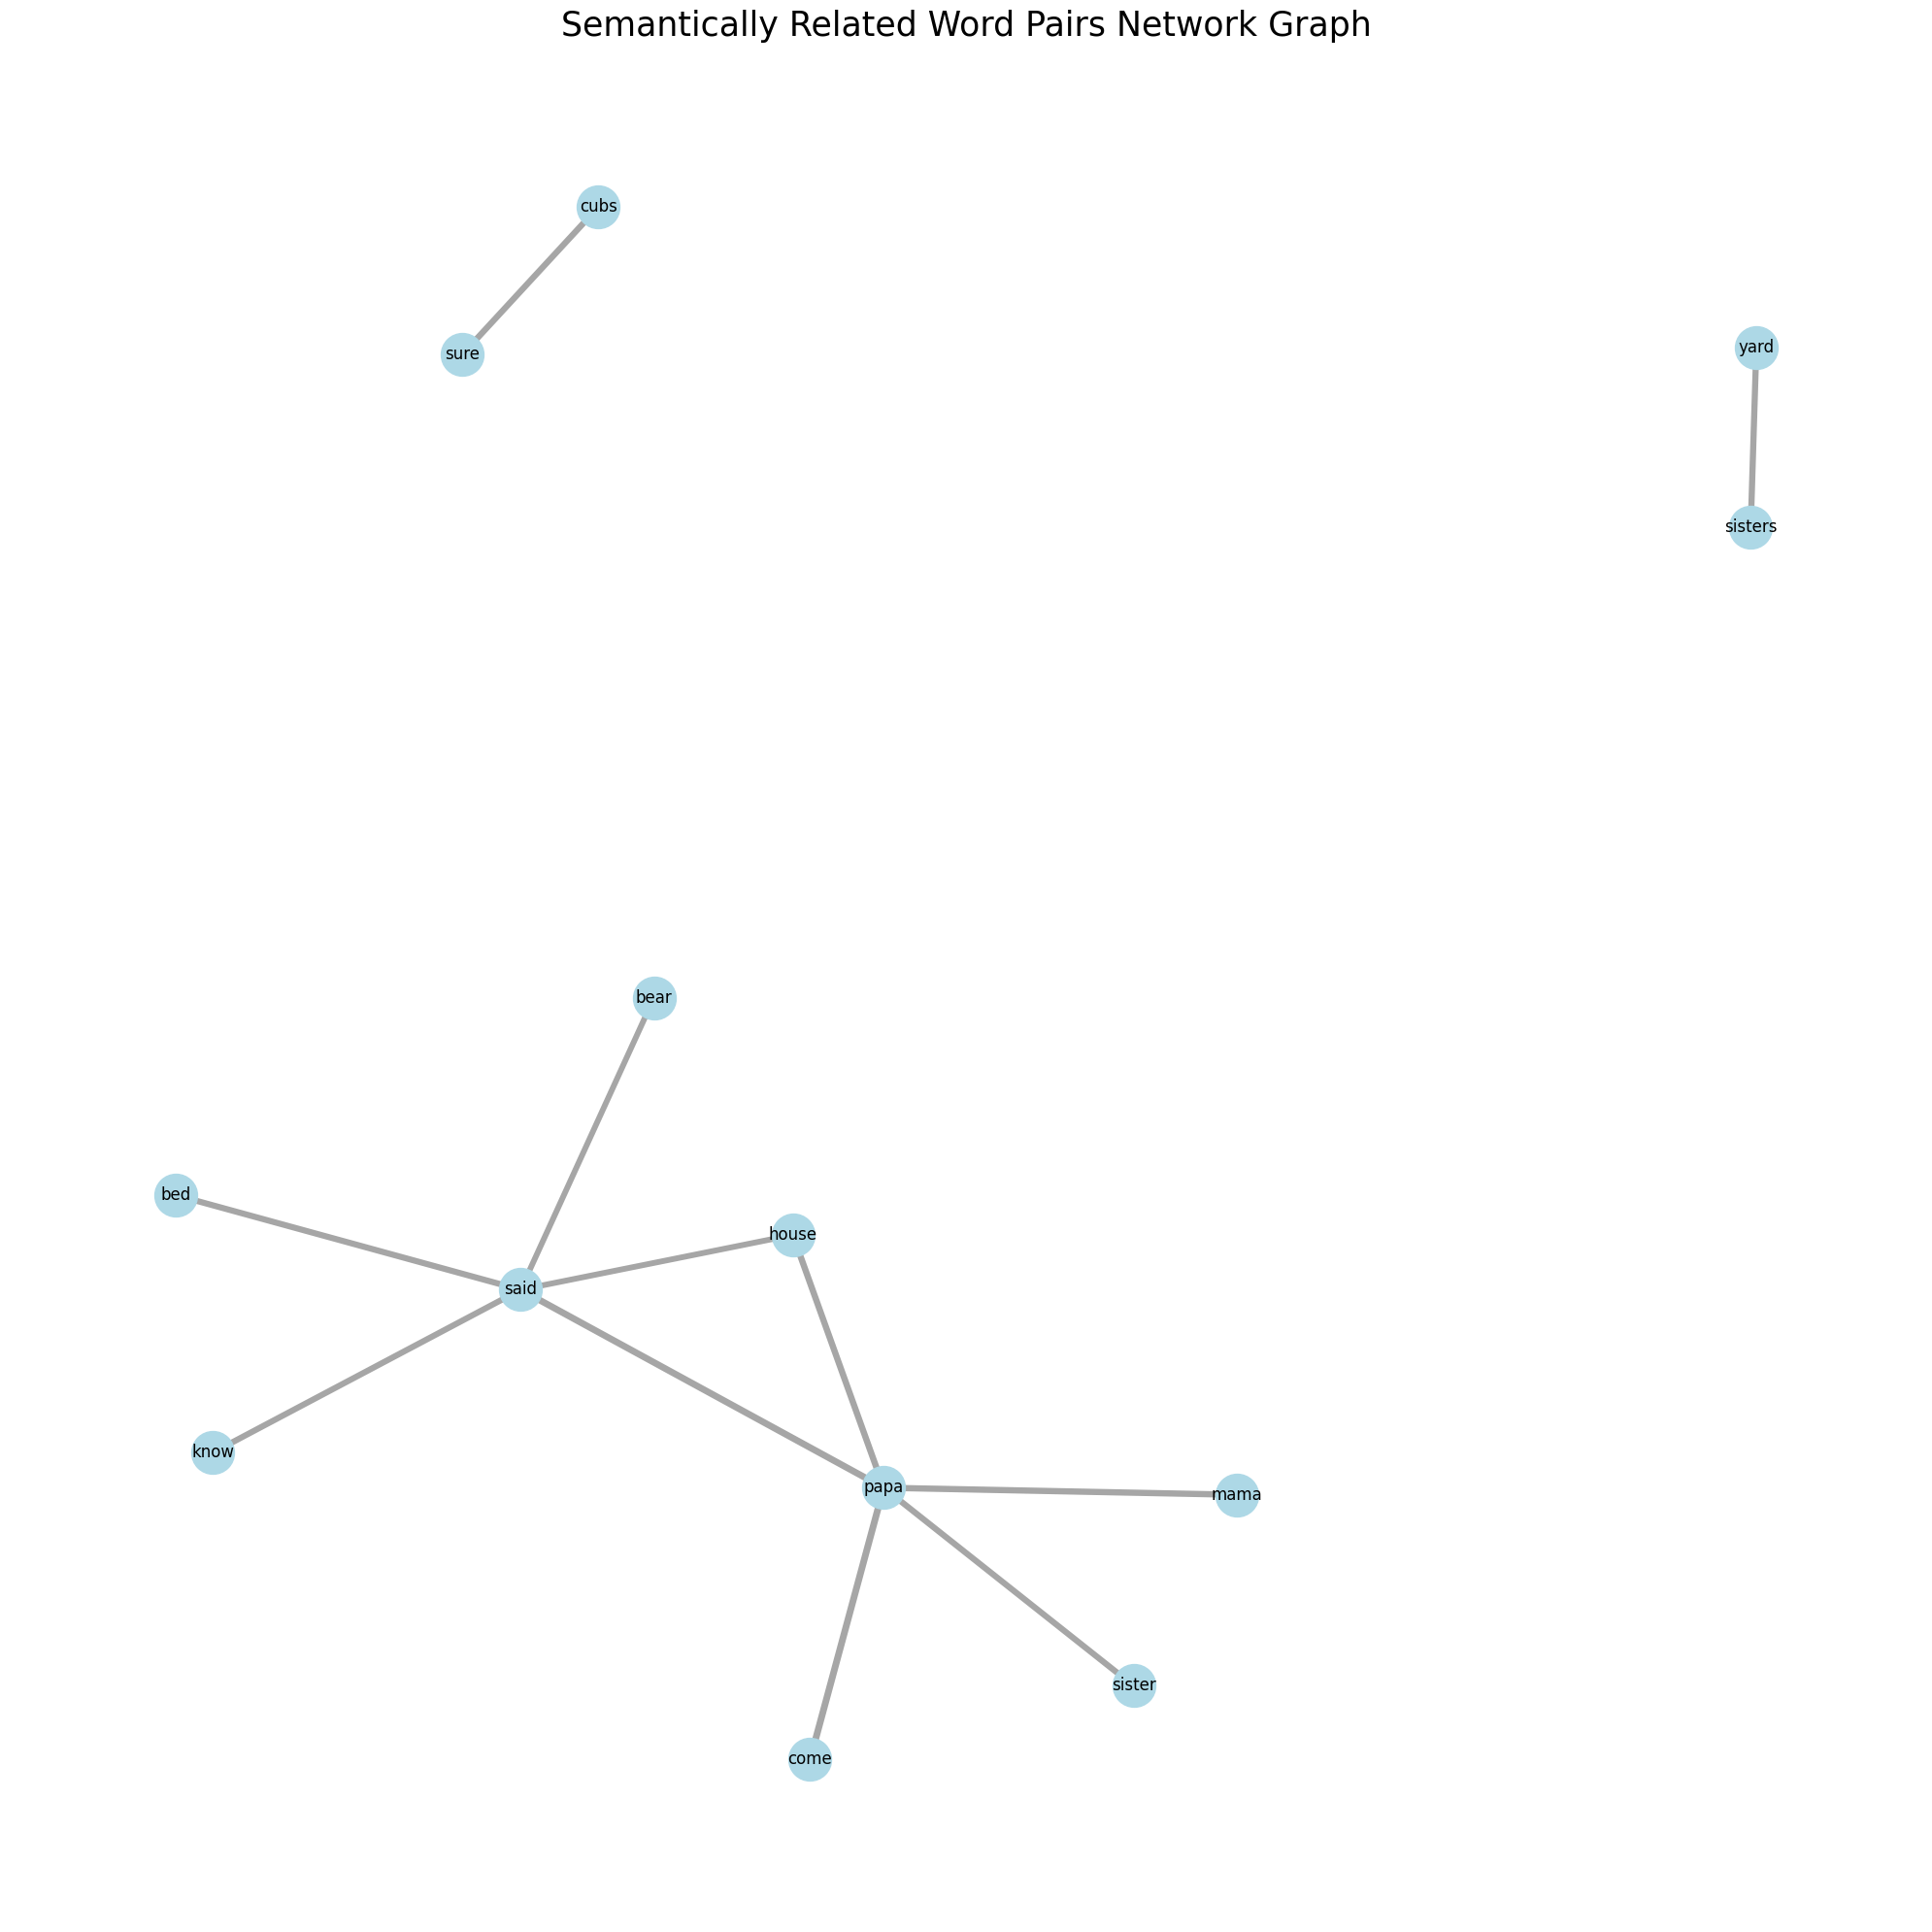

In [ ]:
!pip install gensim

import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        df = pd.read_csv(file_path)
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))

    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            if similar_word in stop_words:
                continue
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]

    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_family.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.5
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_graph_family.png")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Column Names: ['text', 'publish year', 'title', 'category']
Standardized Column Names: ['text', 'publish year', 'title', 'category']
Successfully loaded 8 text entries from 'text' column.
Word2Vec model training completed.

Semantically Related Word Pairs:
said - sister: Similarity = 0.6881
said - sister: Similarity = 0.6881
said - well: Similarity = 0.6830
said - well: Similarity = 0.6830
brother - well: Similarity = 0.6806
brother - well: Similarity = 0.6806
brother - said: Similarity = 0.6787
brother - said: Similarity = 0.6787
brother - oh: Similarity = 0.6549
brother - oh: Similarity = 0.6549
brother - sister: Similarity = 0.6443
brother - sister: Similarity = 0.6443
brother - cubs: Similarity = 0.6398
brother - cubs: Similarity = 0.6398
brother - gramps: Similarity = 0.6397
came - gramps: Similarity = 0.6303
came - gramps: Similarity = 0.6303
said - wasnt: Similarity = 0.6291
said - wasnt: Similarity = 0.6291
got - said: Similarity = 0.6277
got - said: Similarity = 0.627

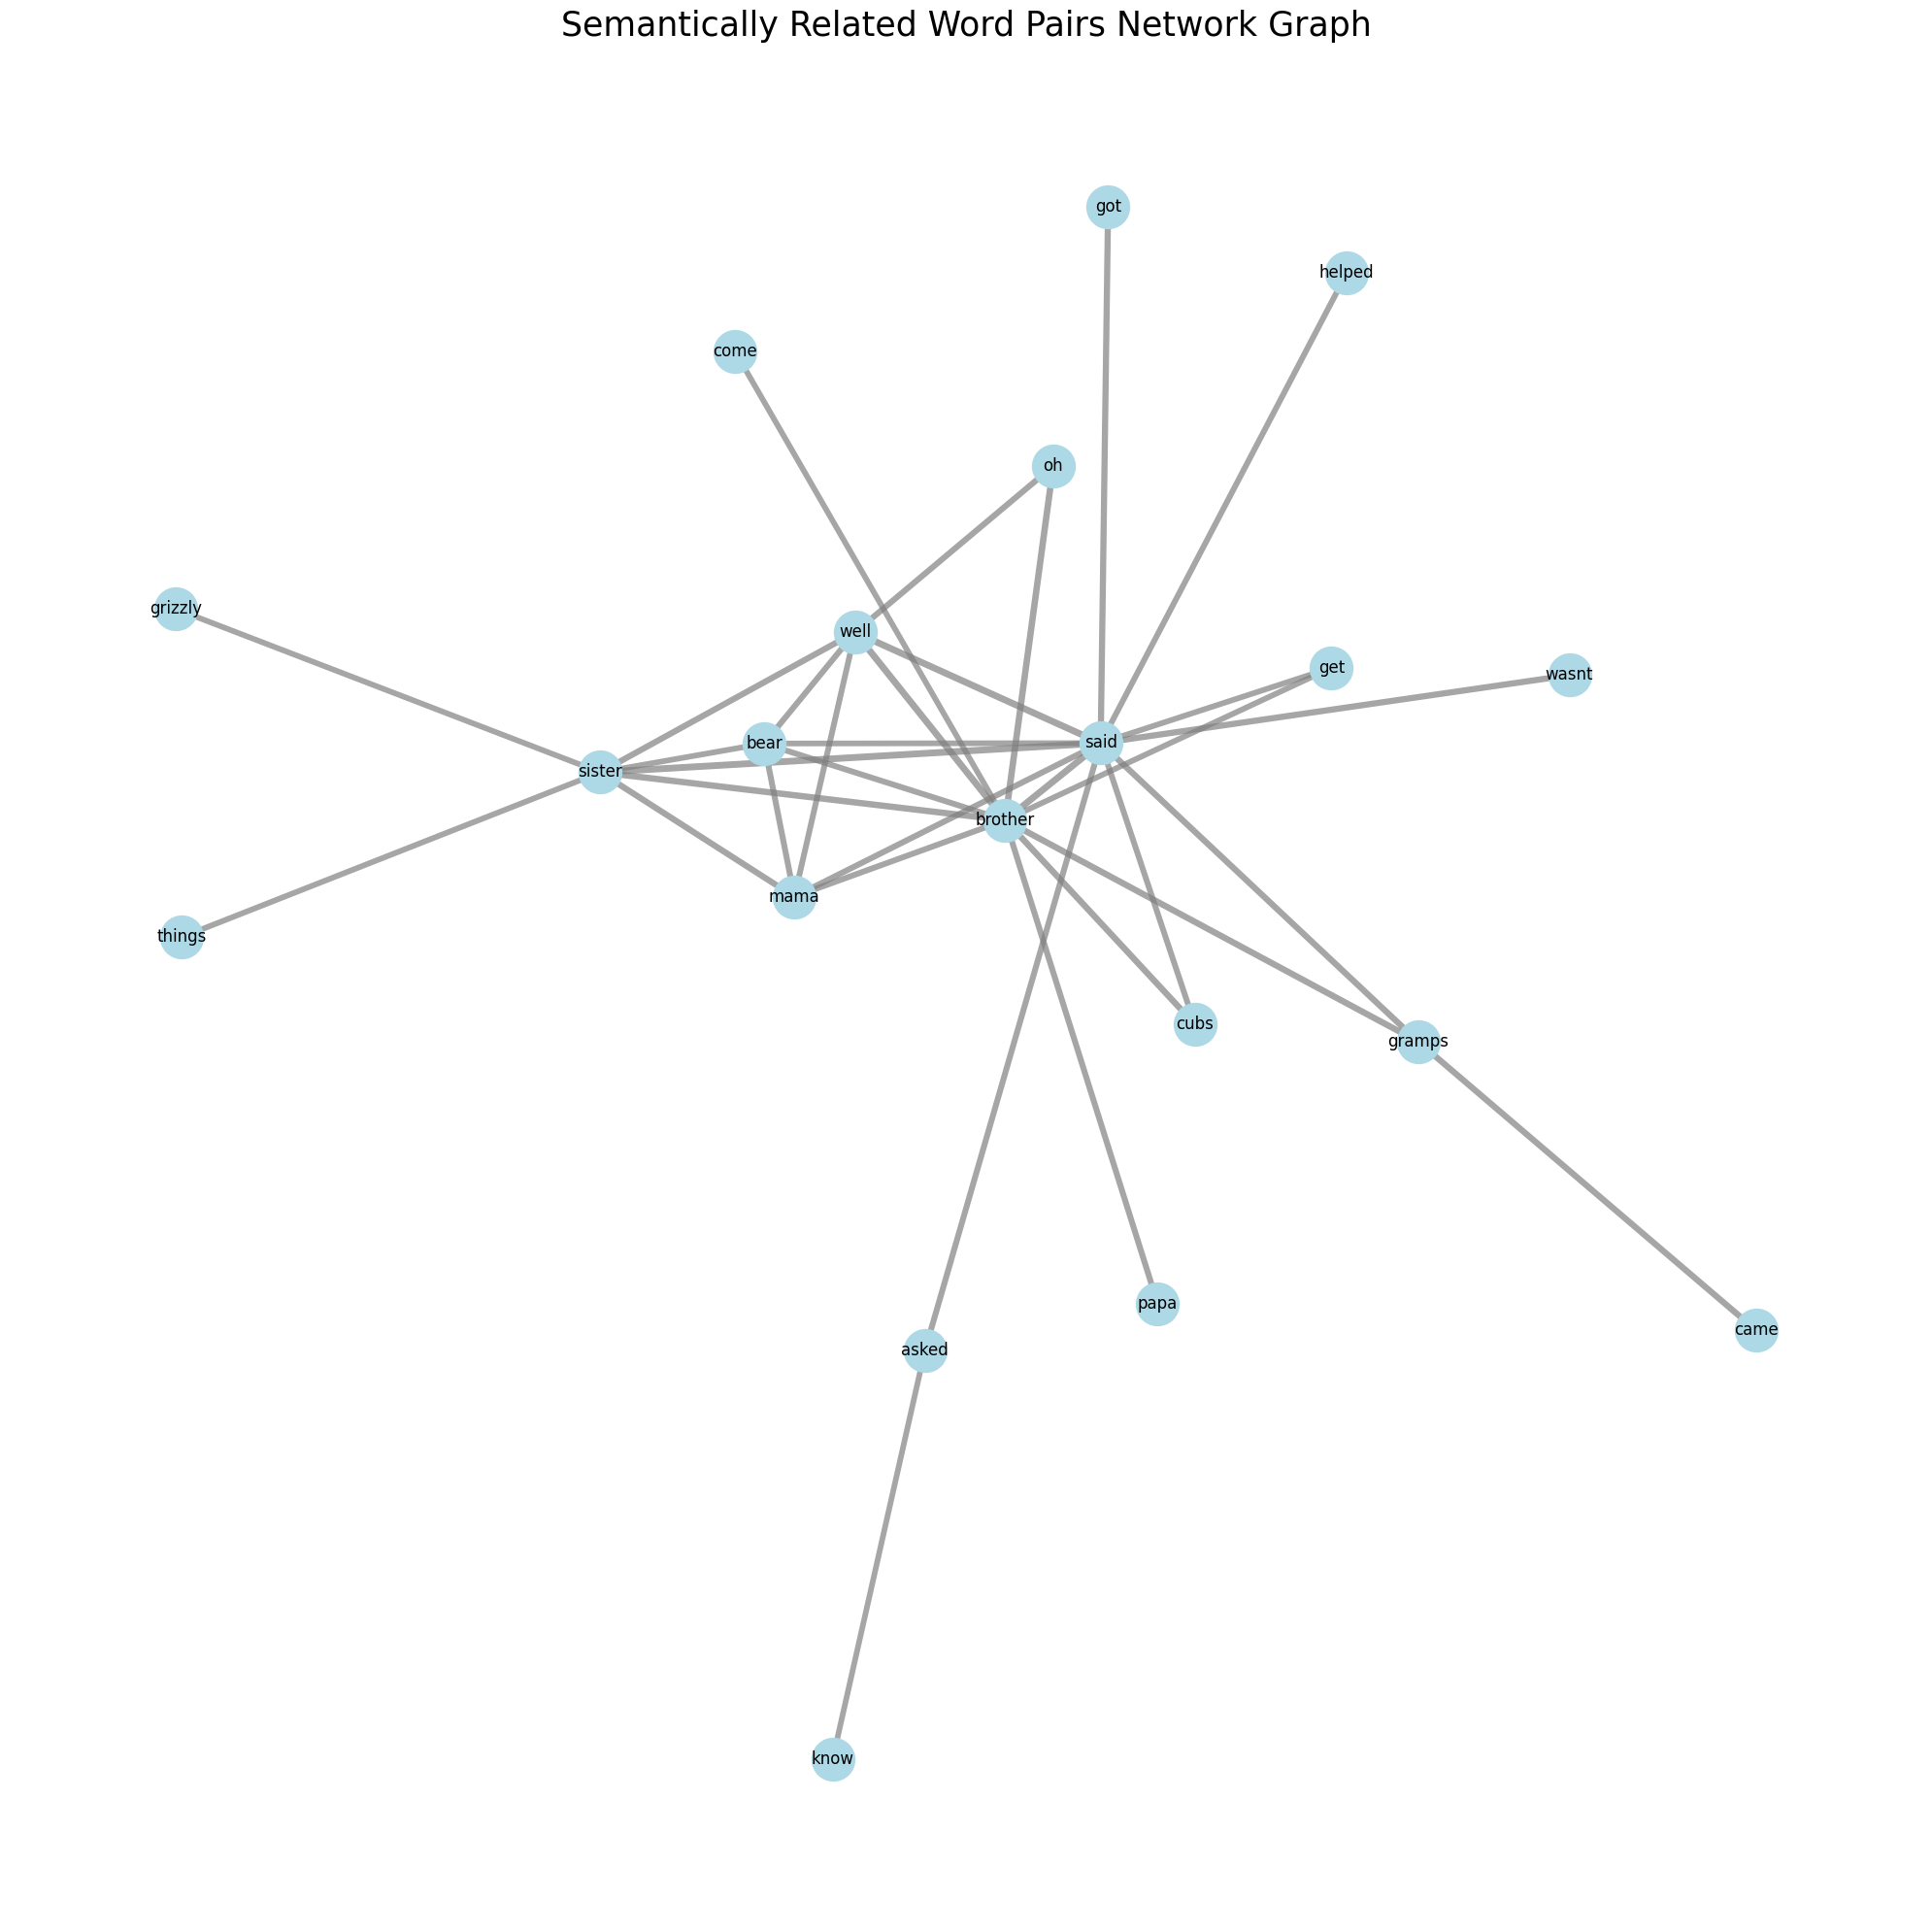

In [ ]:
!pip install gensim

import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        df = pd.read_csv(file_path)
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))

    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            if similar_word in stop_words:
                continue
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]

    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_social.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.5
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_community_graph.png")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Column Names: ['text', 'publish year', 'title', 'category']
Standardized Column Names: ['text', 'publish year', 'title', 'category']
Successfully loaded 8 text entries from 'text' column.
Word2Vec model training completed.

Semantically Related Word Pairs:
said - sister: Similarity = 0.6881
said - sister: Similarity = 0.6881
said - well: Similarity = 0.6830
said - well: Similarity = 0.6830
brother - well: Similarity = 0.6806
brother - well: Similarity = 0.6806
brother - said: Similarity = 0.6787
brother - said: Similarity = 0.6787
brother - oh: Similarity = 0.6549
brother - oh: Similarity = 0.6549
brother - sister: Similarity = 0.6443
brother - sister: Similarity = 0.6443
brother - cubs: Similarity = 0.6398
brother - cubs: Similarity = 0.6398
brother - gramps: Similarity = 0.6397
came - gramps: Similarity = 0.6303
came - gramps: Similarity = 0.6303
said - wasnt: Similarity = 0.6291
said - wasnt: Similarity = 0.6291
got - said: Similarity = 0.6277
got - said: Similarity = 0.627

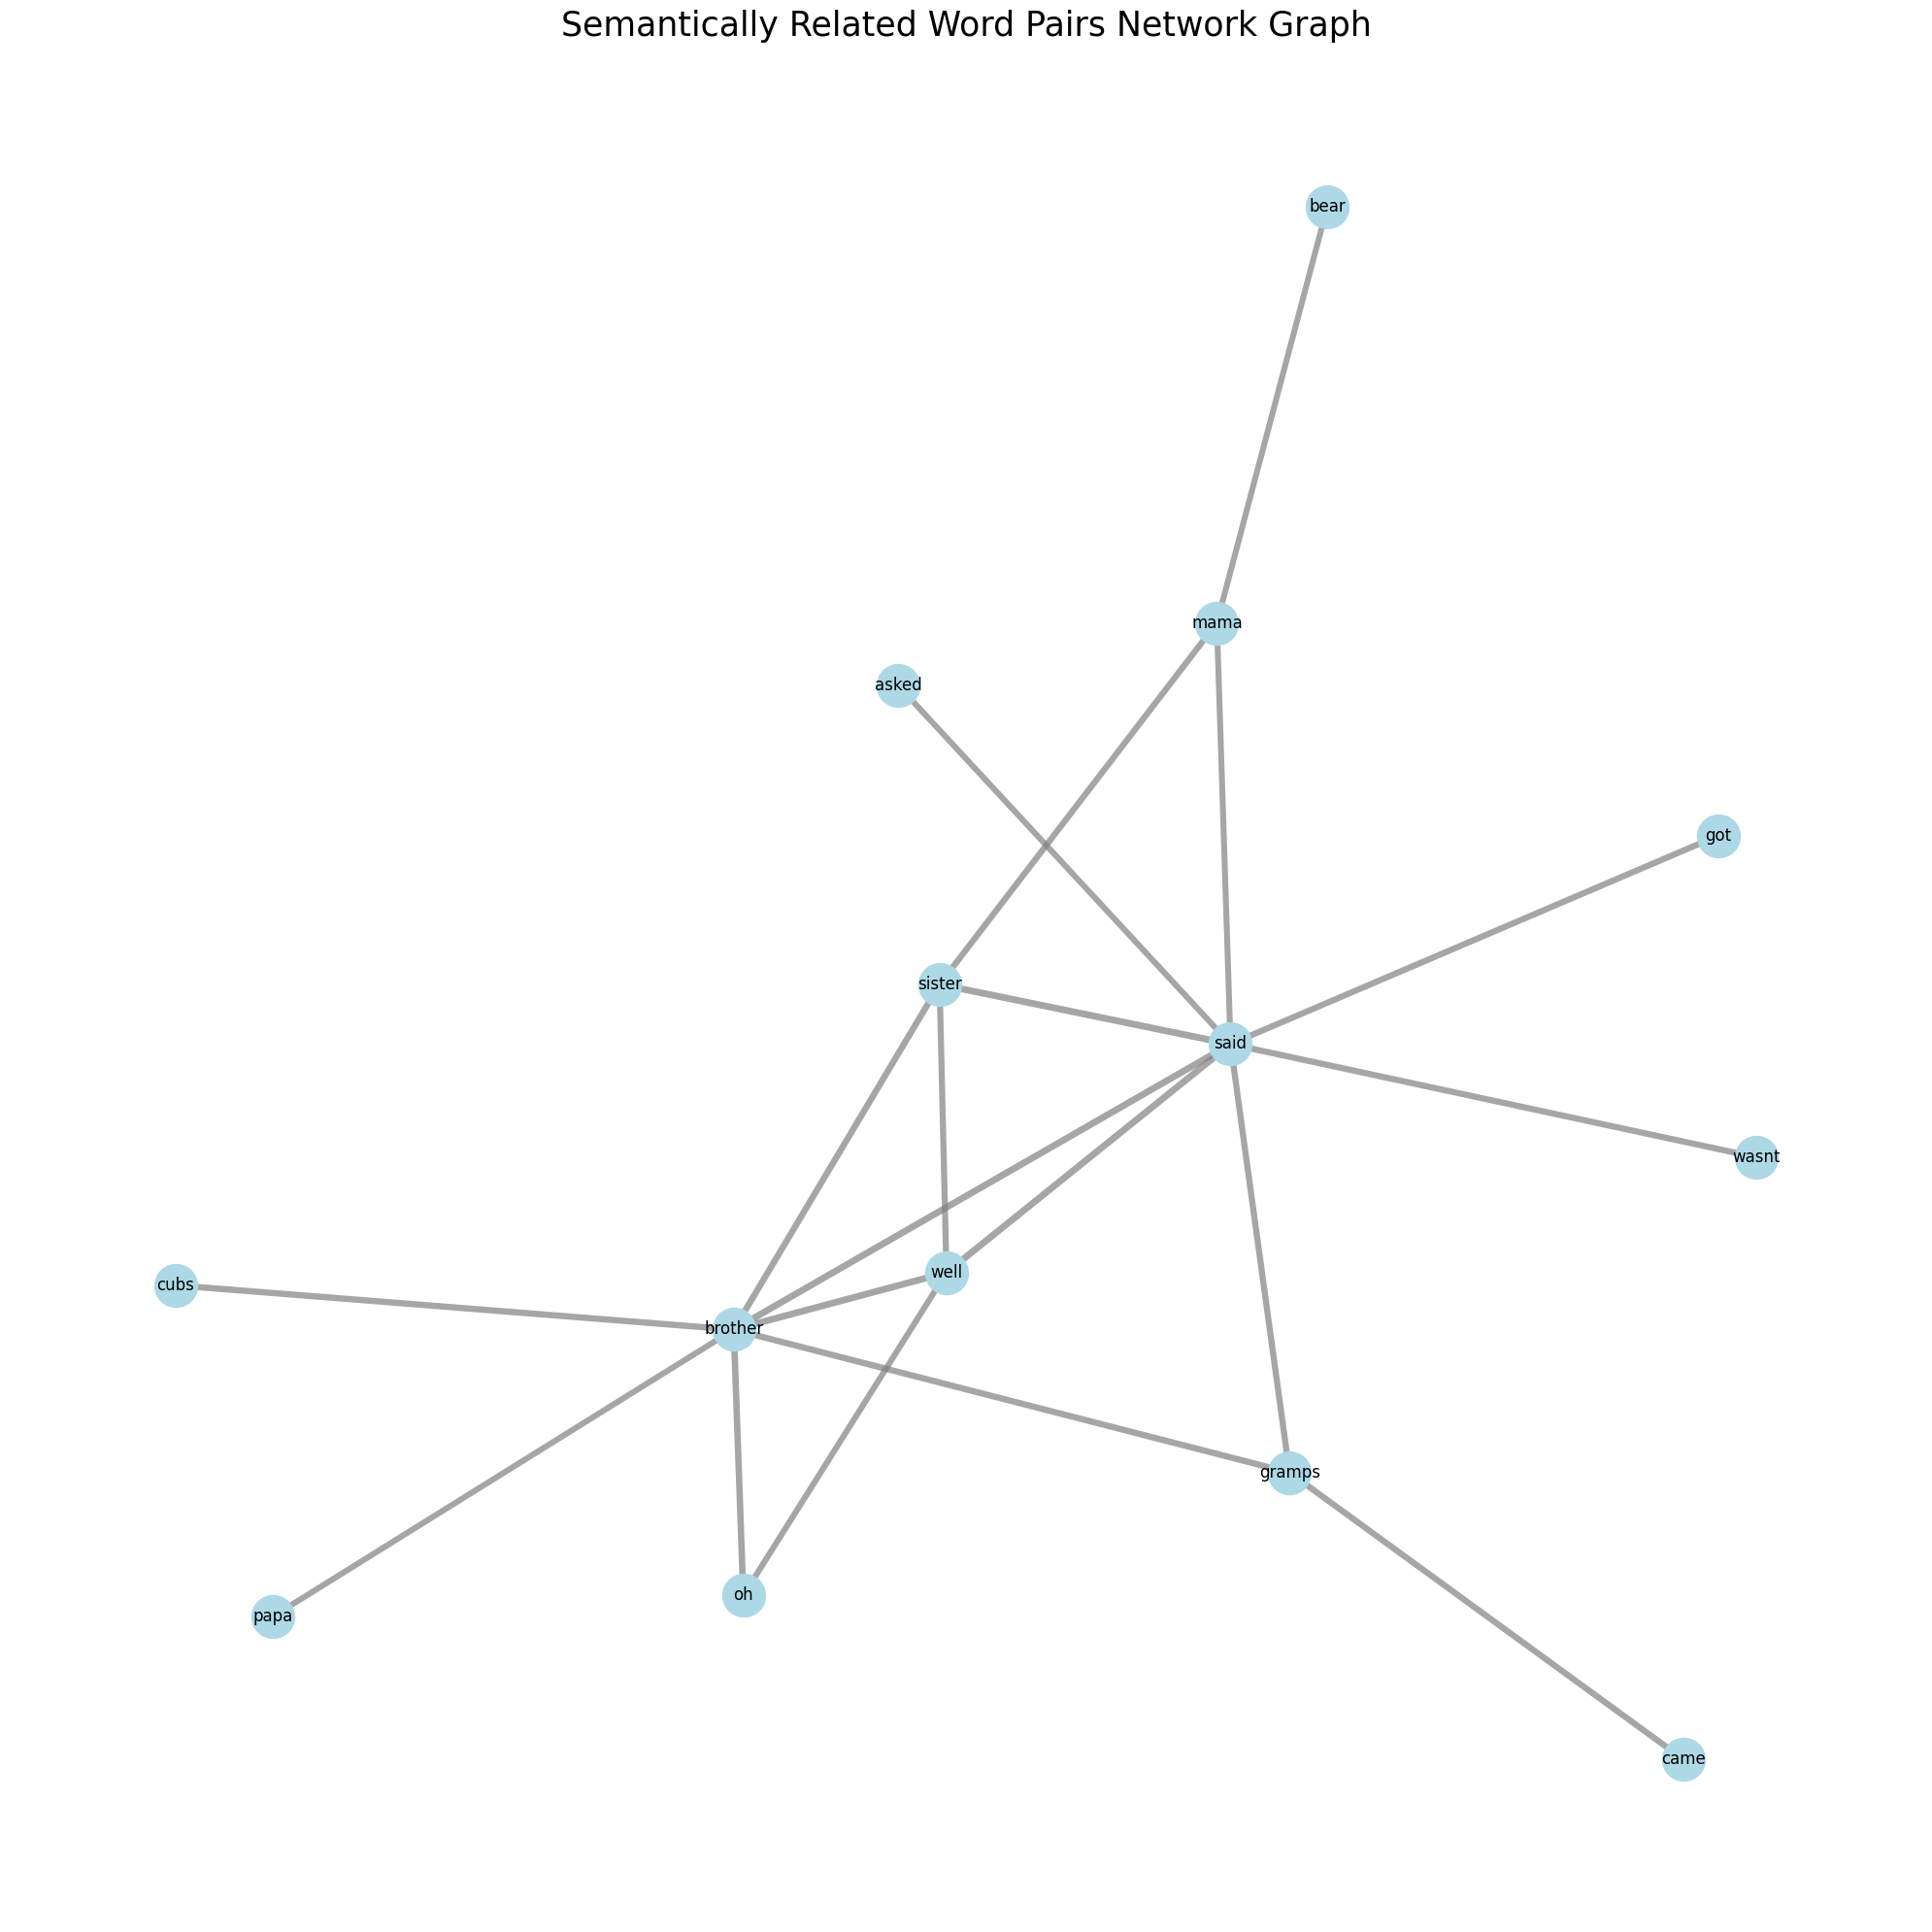

In [ ]:
!pip install gensim

import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        df = pd.read_csv(file_path)
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))

    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            if similar_word in stop_words:
                continue
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]

    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_social.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.6
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_community_higherthreshold_graph.png")

if __name__ == "__main__":
    main()

phrase-level semantic similarity for family narratives

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
No edges meet the similarity threshold.


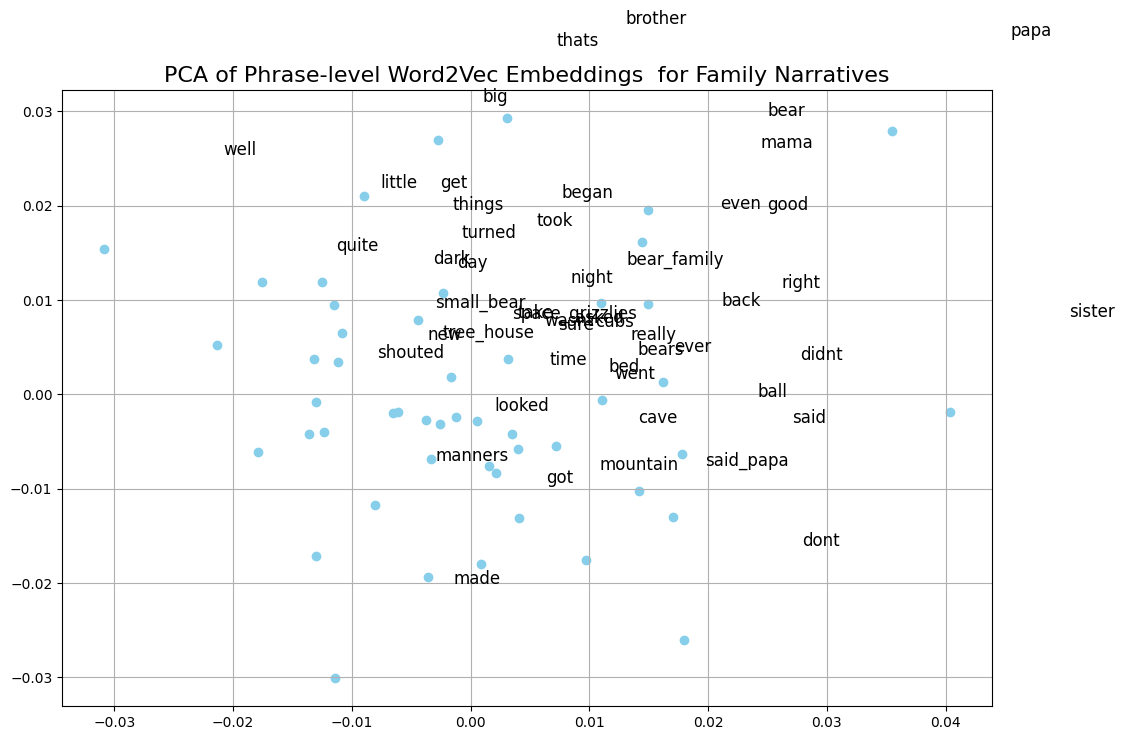

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


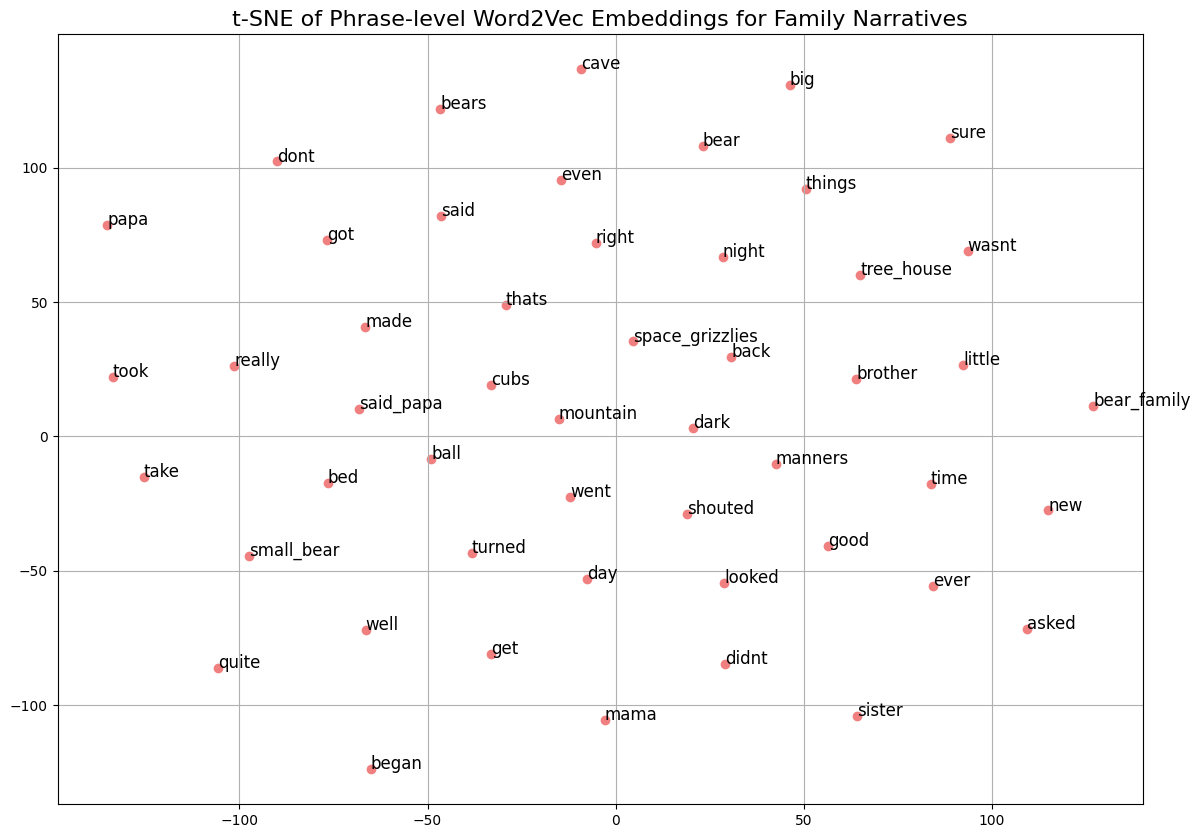

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings  for Family Narratives", fontsize=16)  #🍏🍏🍏🍏🍏
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings for Family Narratives", fontsize=16)  #🍏🍏🍏🍏🍏
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_family.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.6,
                           save_path="/content/semantically_related_phrase_pairs_graph_family.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()

phrase-level graph with connecting lines for family narratives

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
No edges meet the similarity threshold.


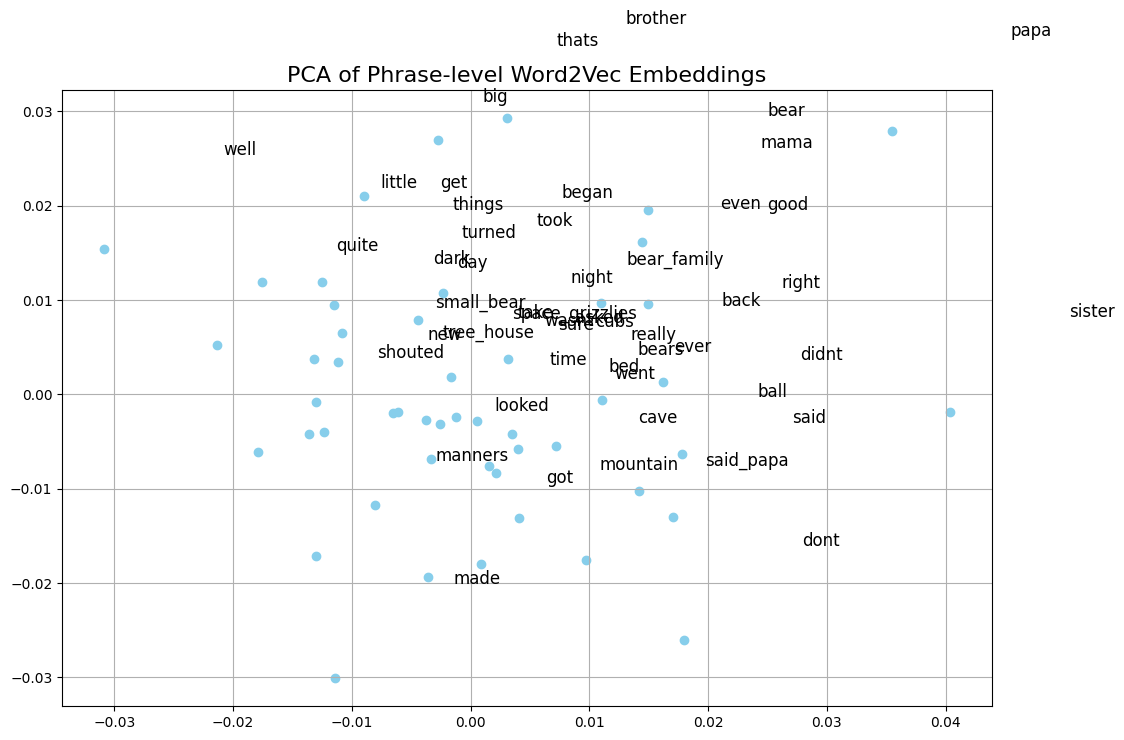

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


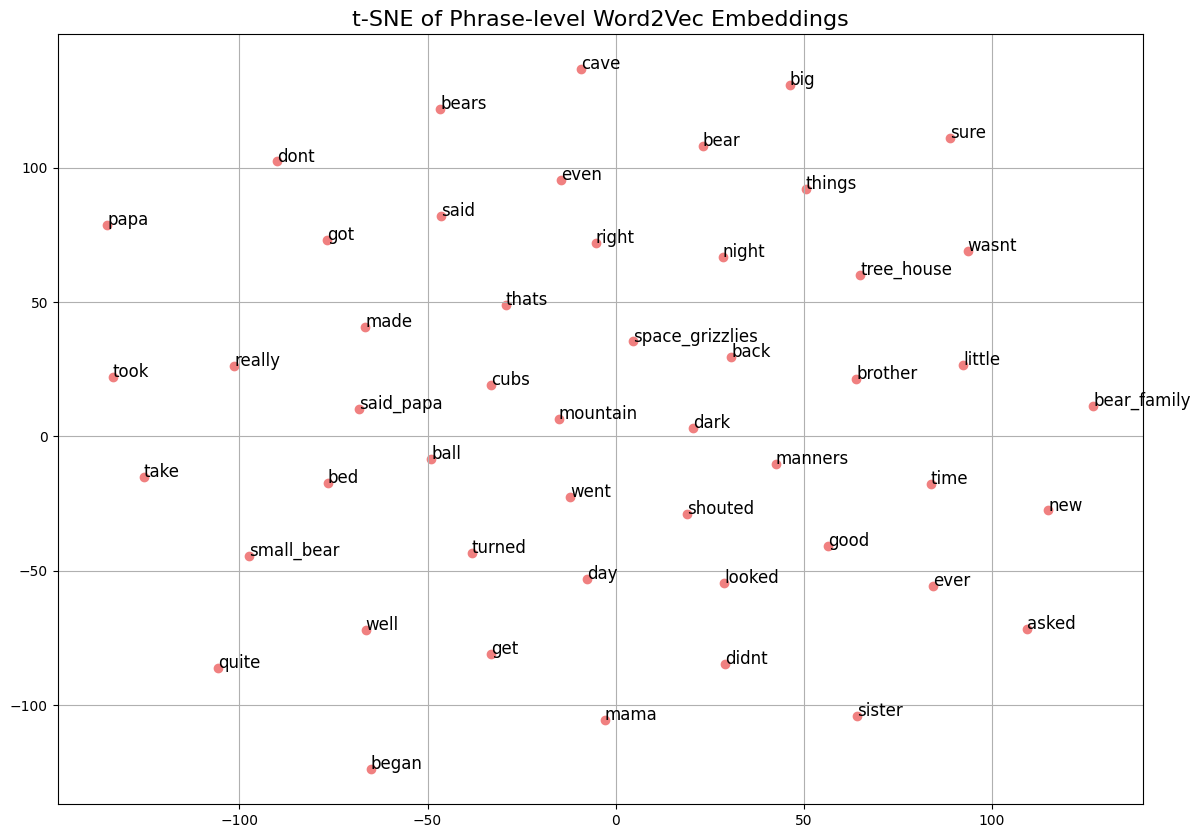

Loaded 8 text entries from 'text'.
Word2Vec model training completed.

Semantically Related Word Pairs:
come - papa: Similarity = 0.5887
come - papa: Similarity = 0.5887
papa - said: Similarity = 0.5758
papa - said: Similarity = 0.5758
house - papa: Similarity = 0.5484
house - papa: Similarity = 0.5484
mama - papa: Similarity = 0.5468
mama - papa: Similarity = 0.5468
sisters - yard: Similarity = 0.5360
sisters - yard: Similarity = 0.5360
cubs - sure: Similarity = 0.5354
cubs - sure: Similarity = 0.5354
bed - said: Similarity = 0.5302
bed - said: Similarity = 0.5302
papa - sister: Similarity = 0.5290
papa - sister: Similarity = 0.5290
know - said: Similarity = 0.5235
know - said: Similarity = 0.5235
house - said: Similarity = 0.5026
house - said: Similarity = 0.5026
bear - said: Similarity = 0.5009
bear - said: Similarity = 0.5009
made - said: Similarity = 0.4981
mama - said: Similarity = 0.4948
come - mama: Similarity = 0.4944
come - mama: Similarity = 0.4944
come - house: Similarity =

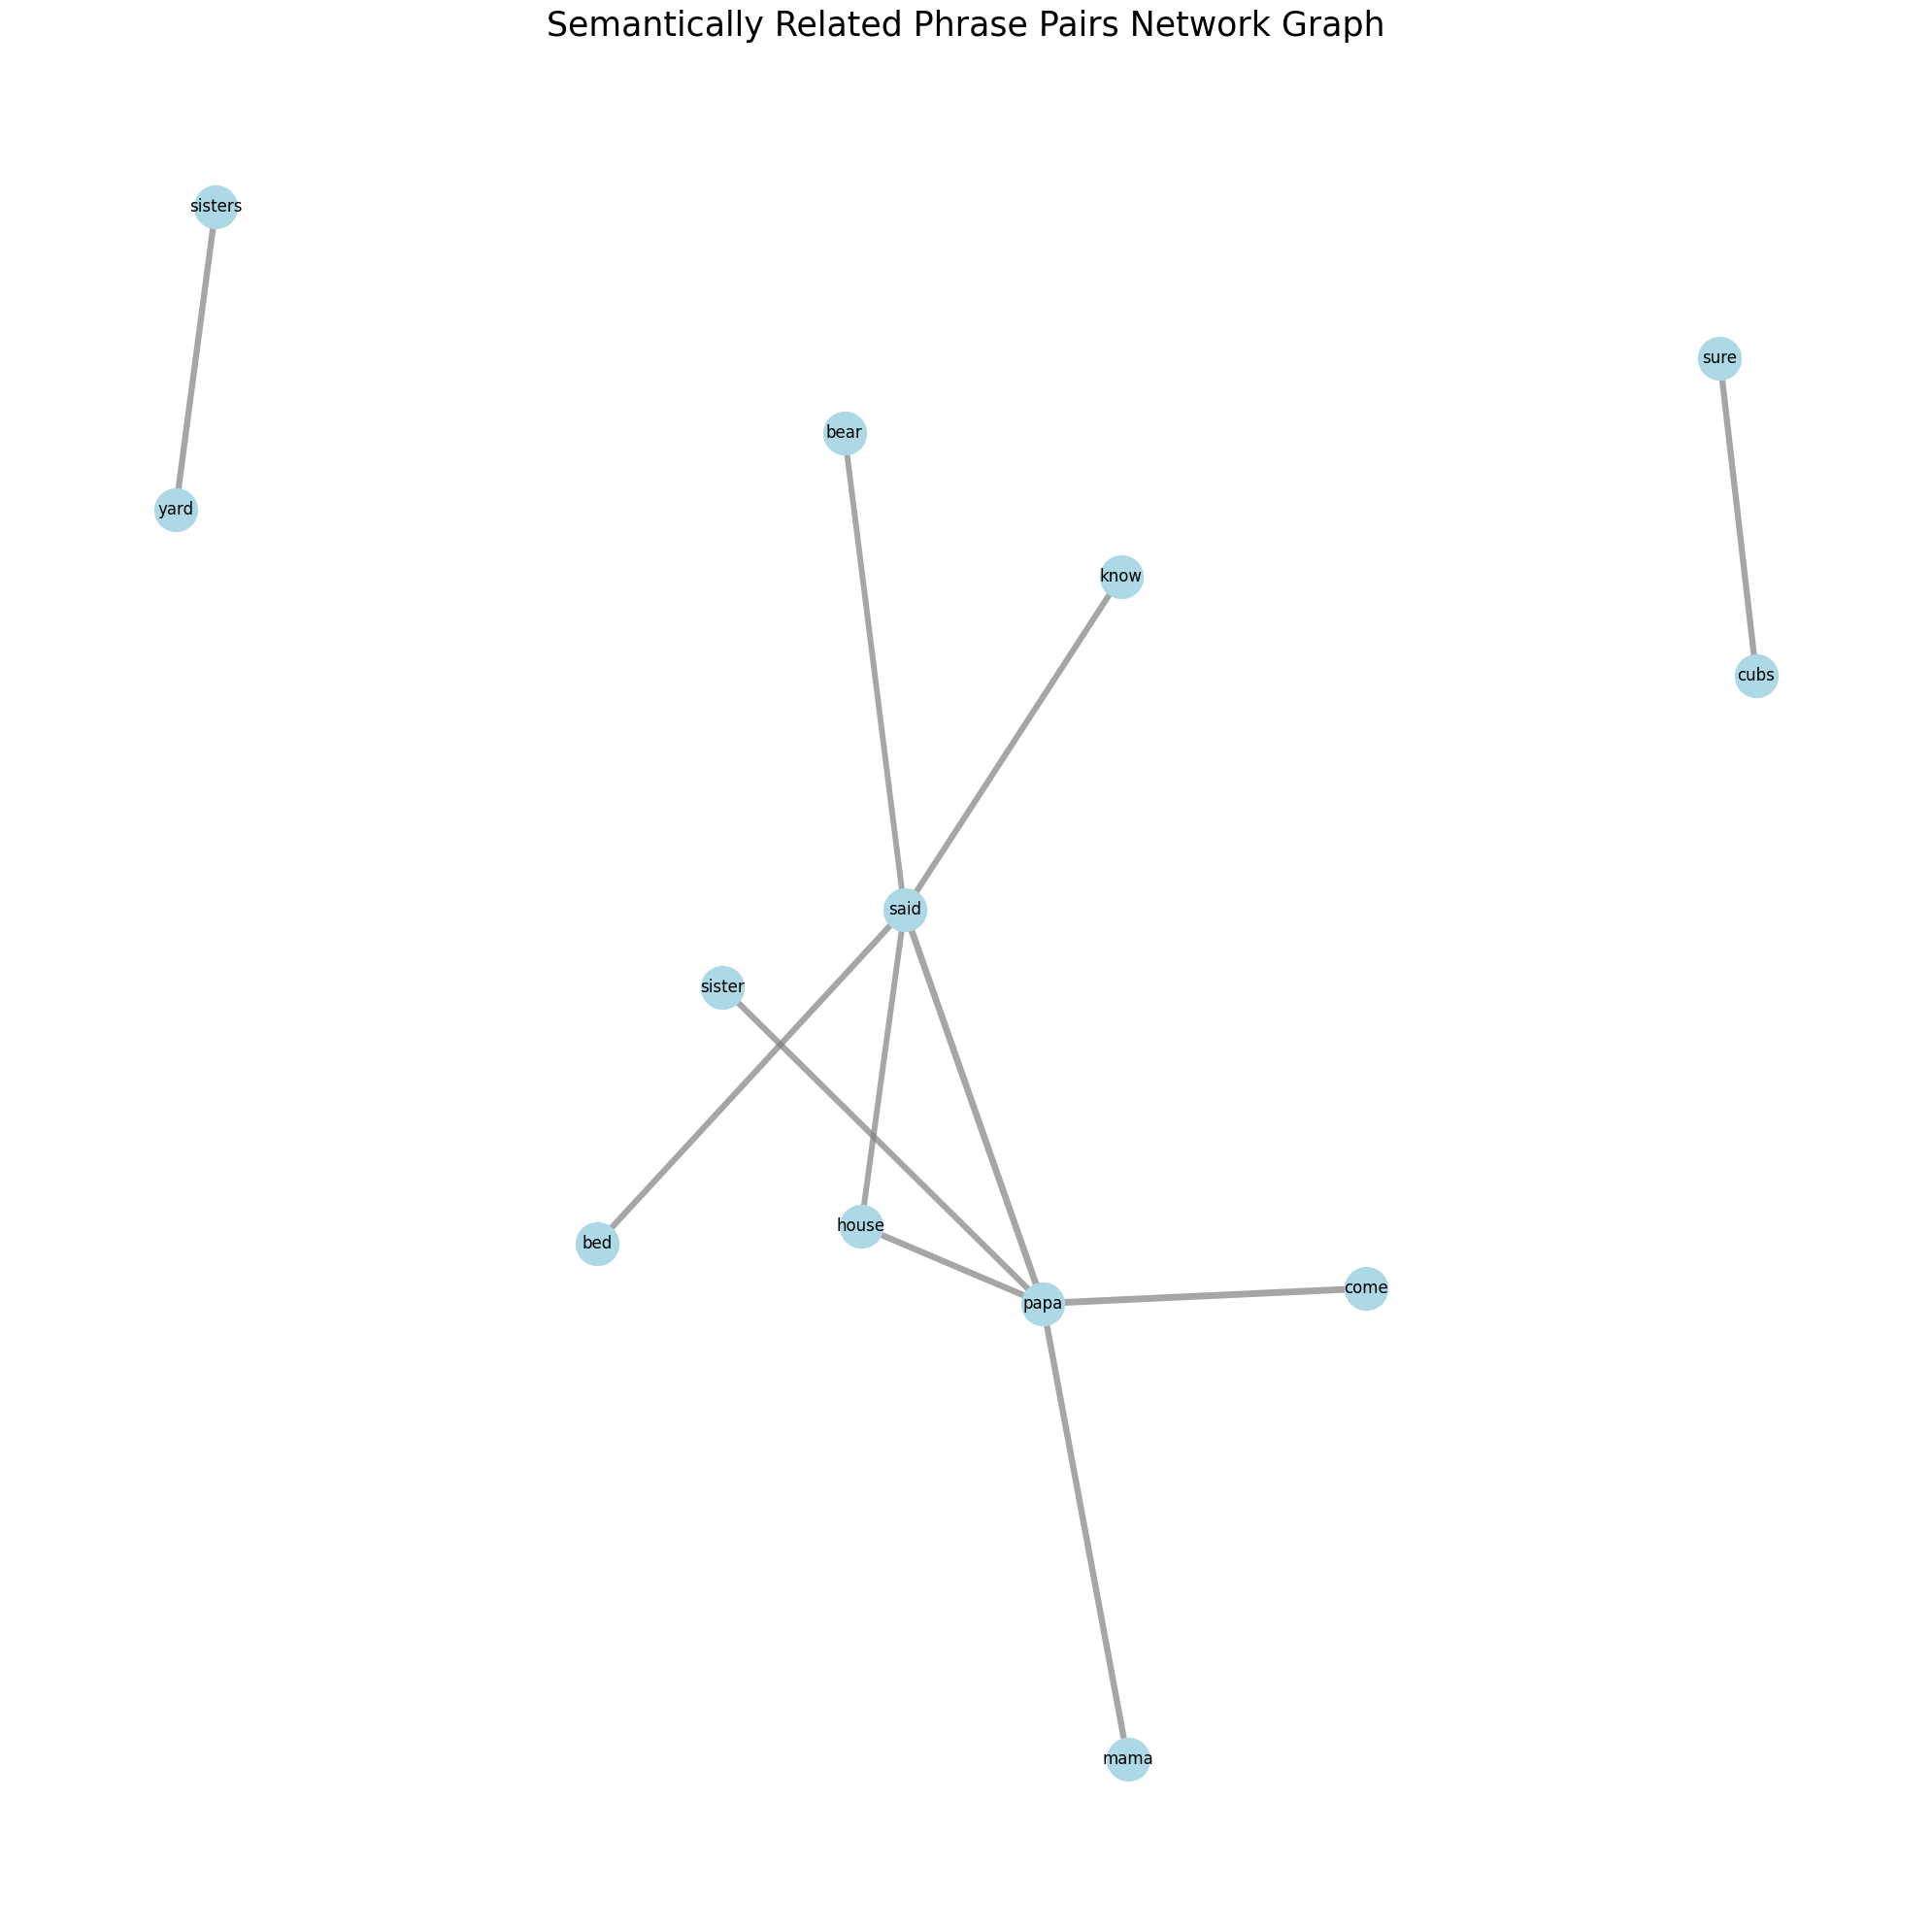

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_family.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.6,
                           save_path="/content/semantically_related_phrase_pairs_graph_family.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()






    # Step : Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_family.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.5
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_phrase_pairs_family_graph.png")

if __name__ == "__main__":
    main()

phrase-level semantic similarity for community narratives

threshold of 0.5

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
Graph saved to '/content/semantically_related_phrase_pairs_social_graph.png'


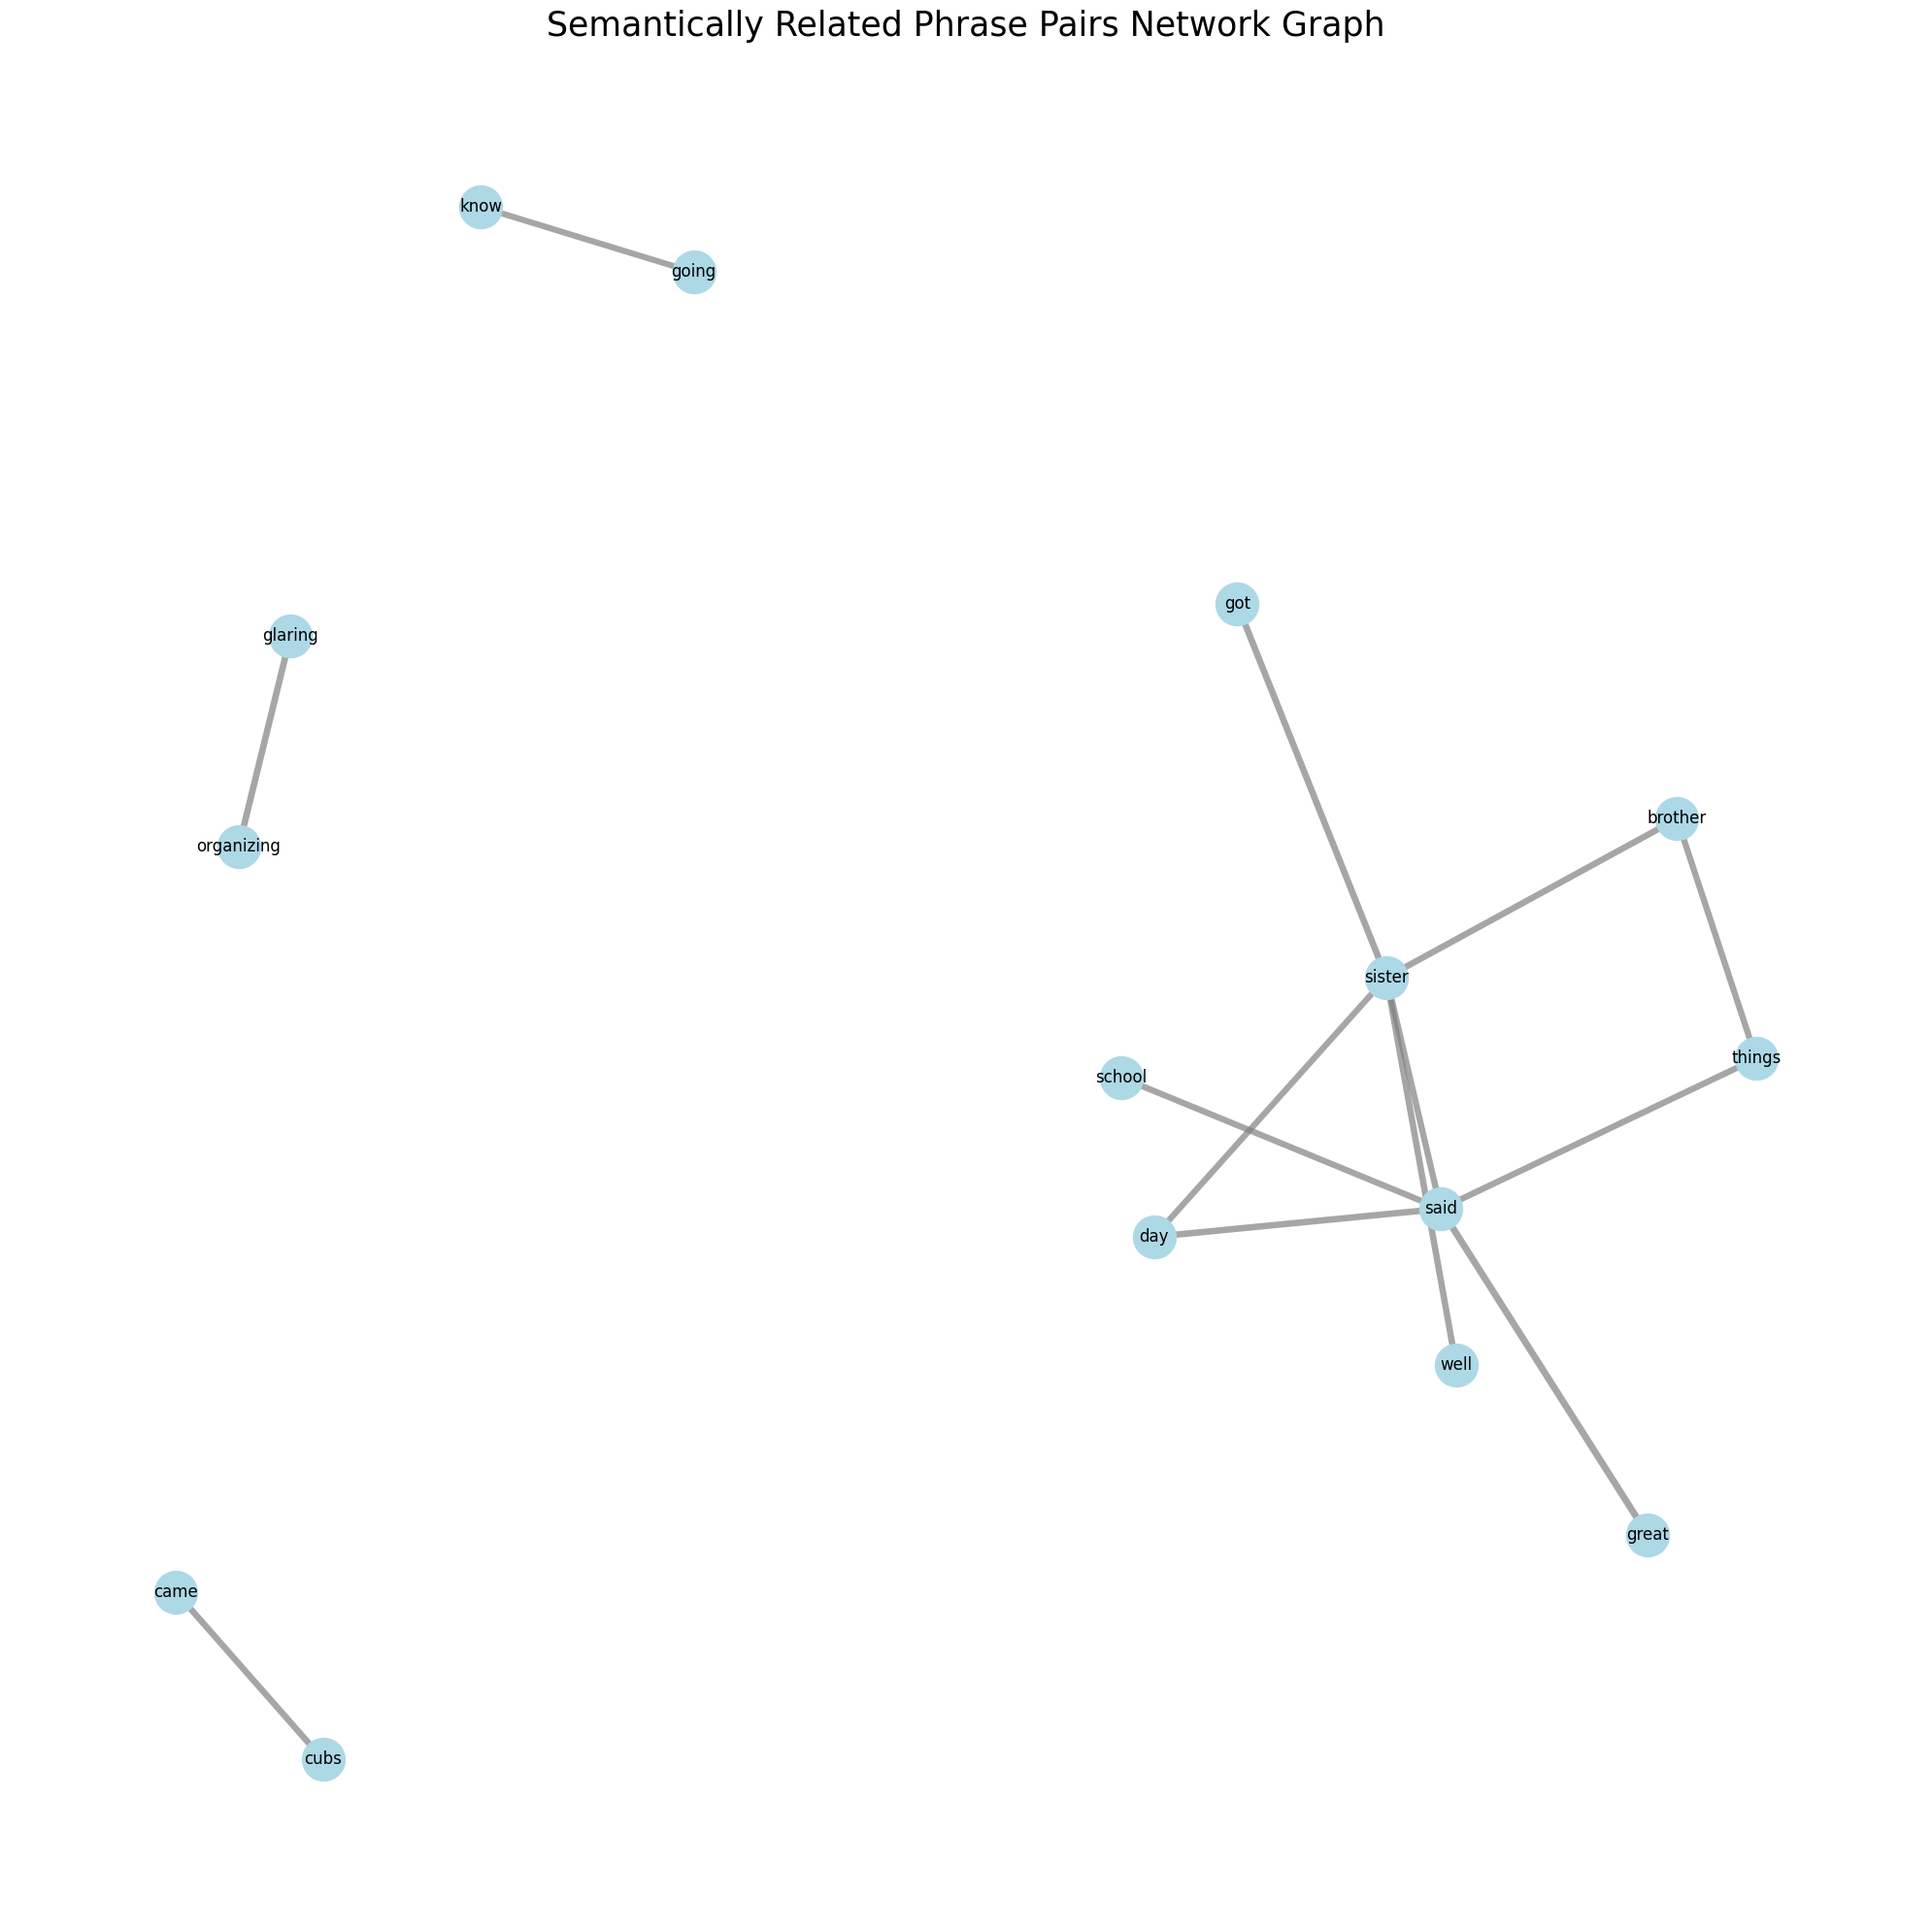

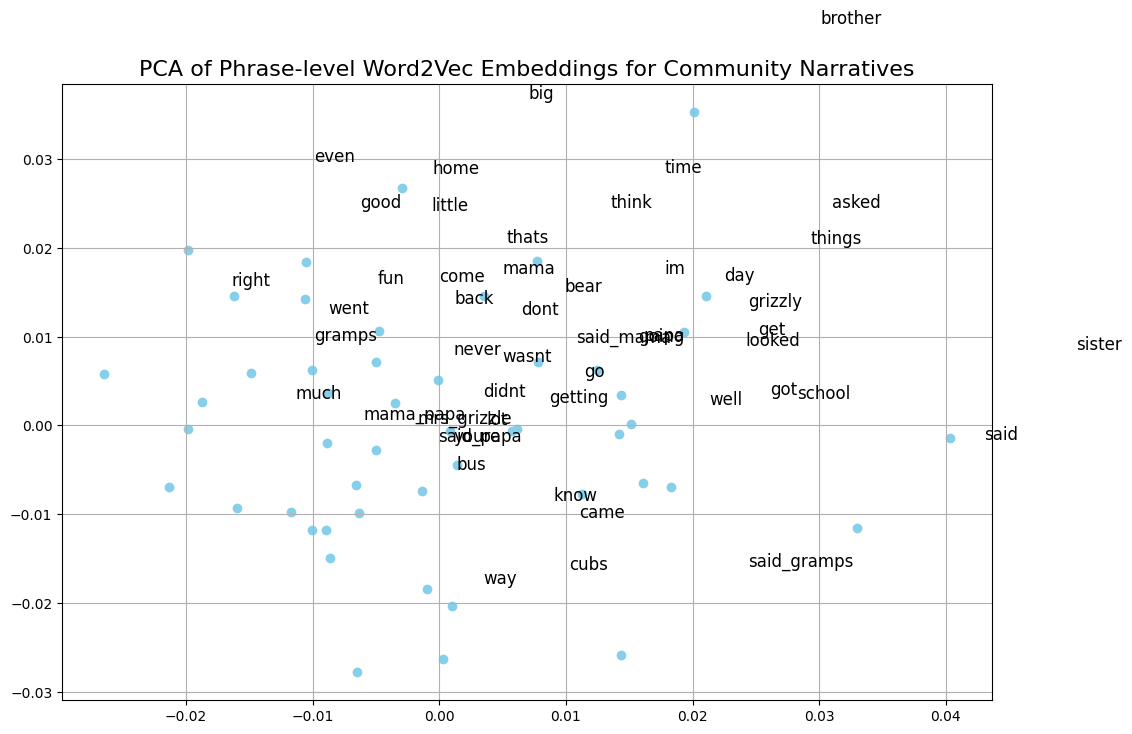

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


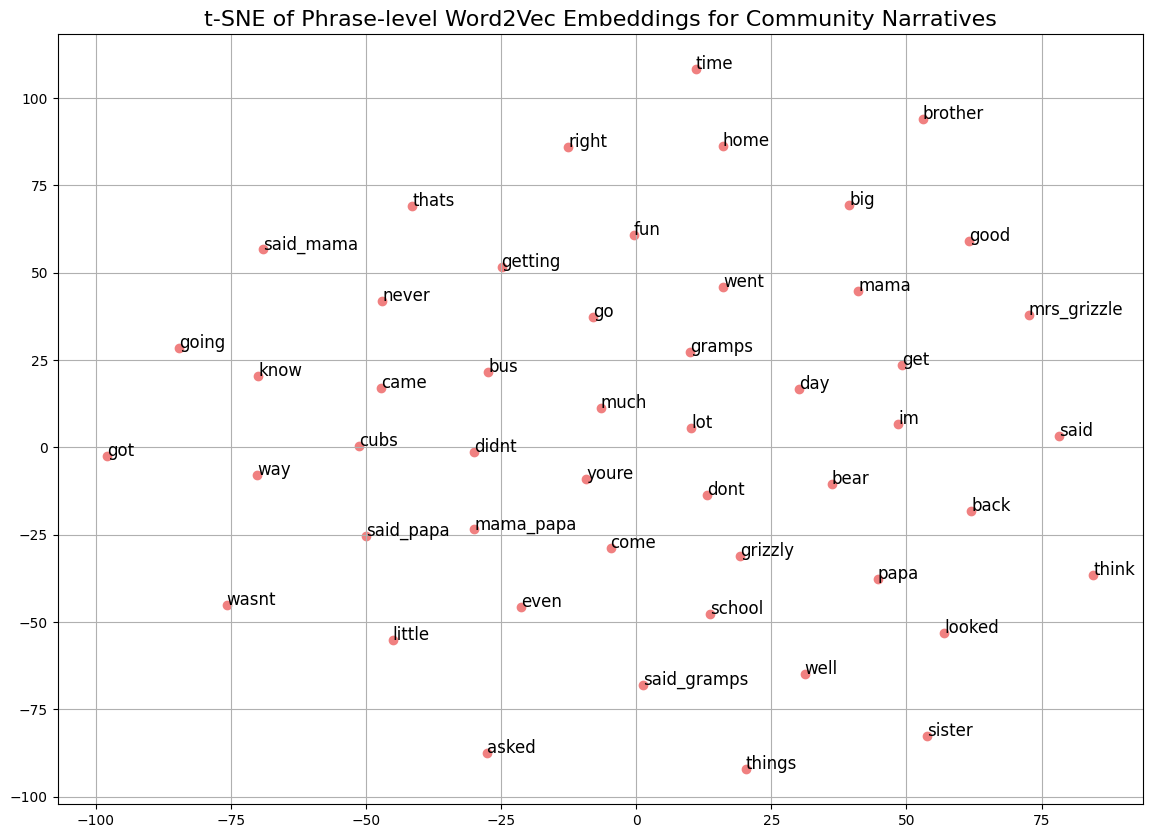

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings for Community Narratives", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings for Community Narratives", fontsize=16)
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_social.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.5,
                           save_path="/content/semantically_related_phrase_pairs_social_graph.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()

threshold of 0.6 for family narrative

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
No edges meet the similarity threshold.


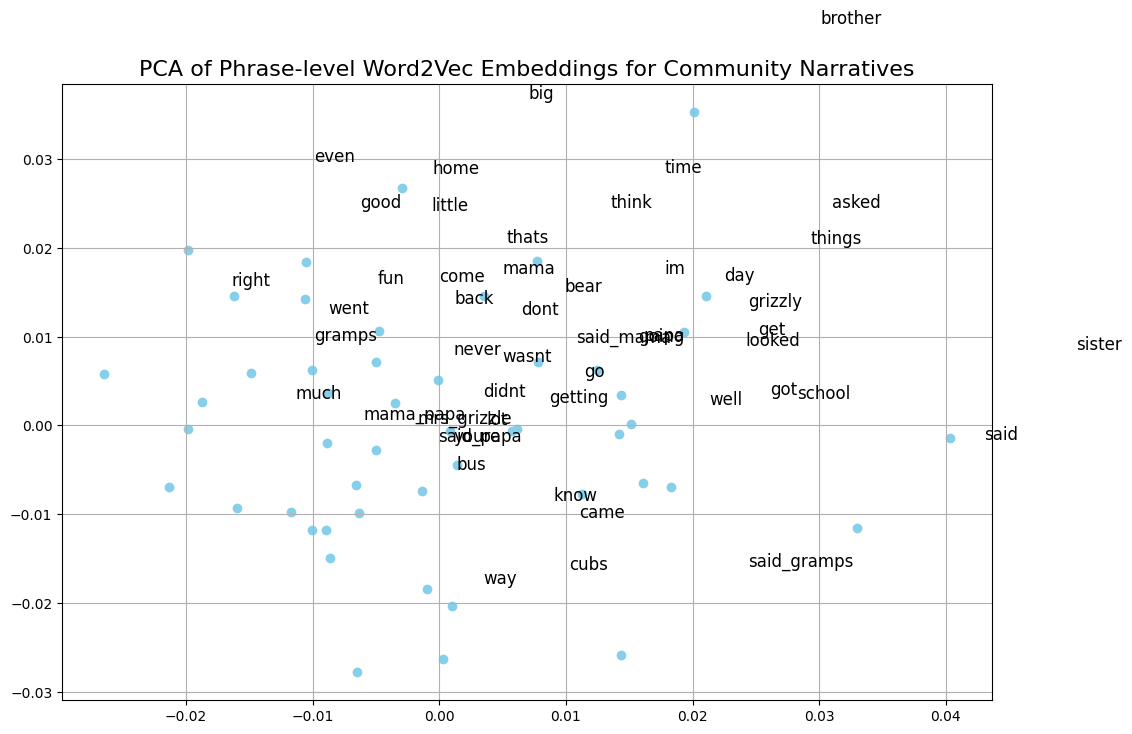

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


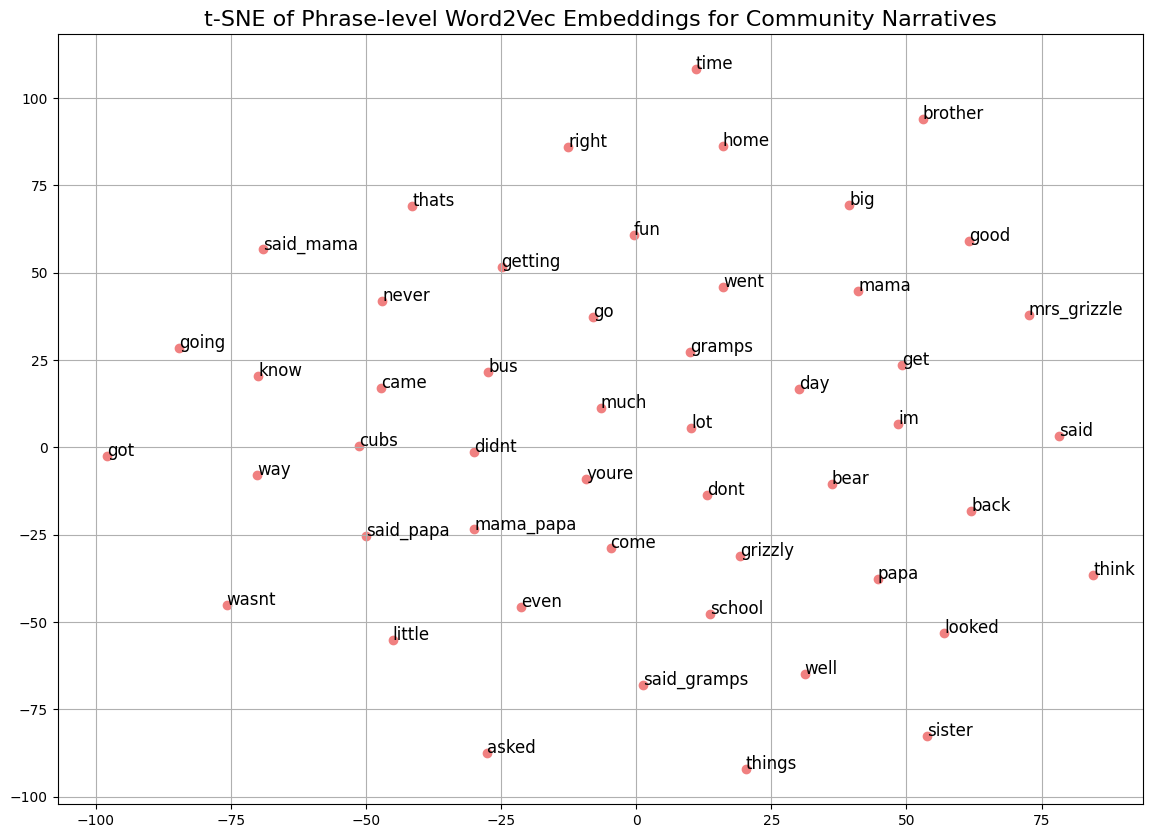

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings for Community Narratives", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings for Community Narratives", fontsize=16)
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_social.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.6,
                           save_path="/content/semantically_related_phrase_pairs_social_graph.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()

Semantic similarity graph with connecting lines for community narratives (threshold of 0.5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
Graph saved to '/content/semantically_related_phrase_pairs_community_graph.png'


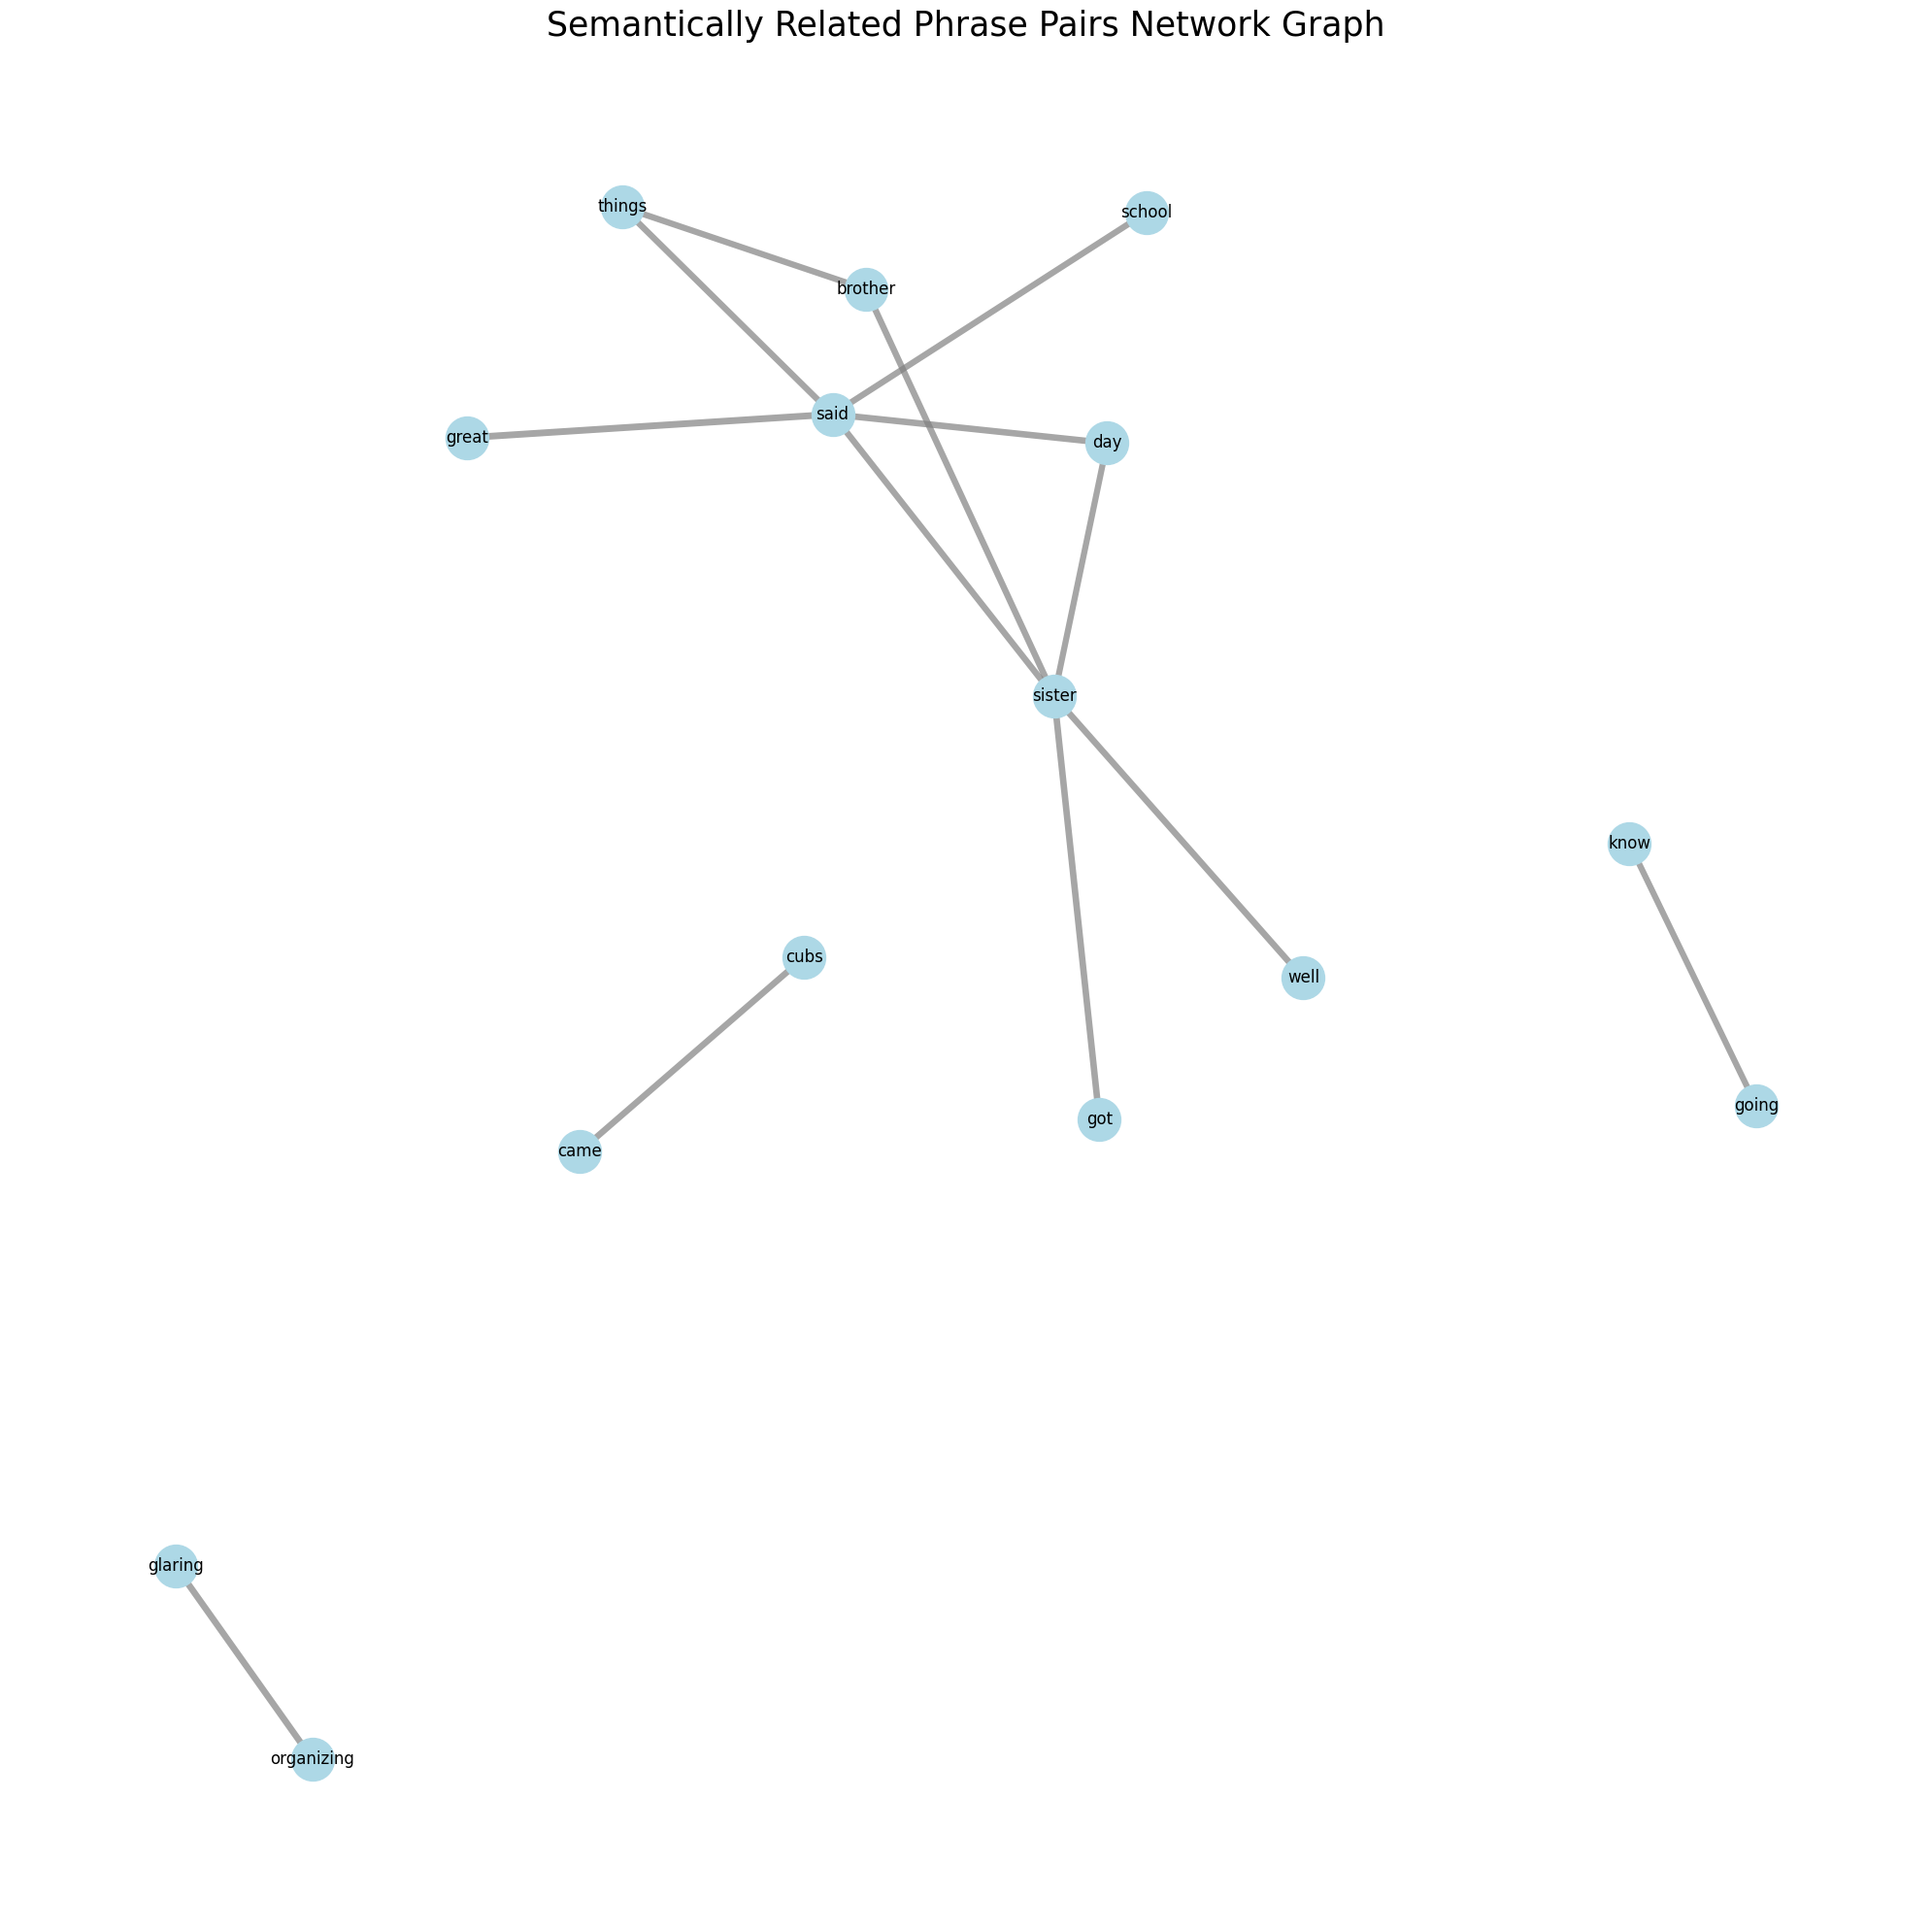

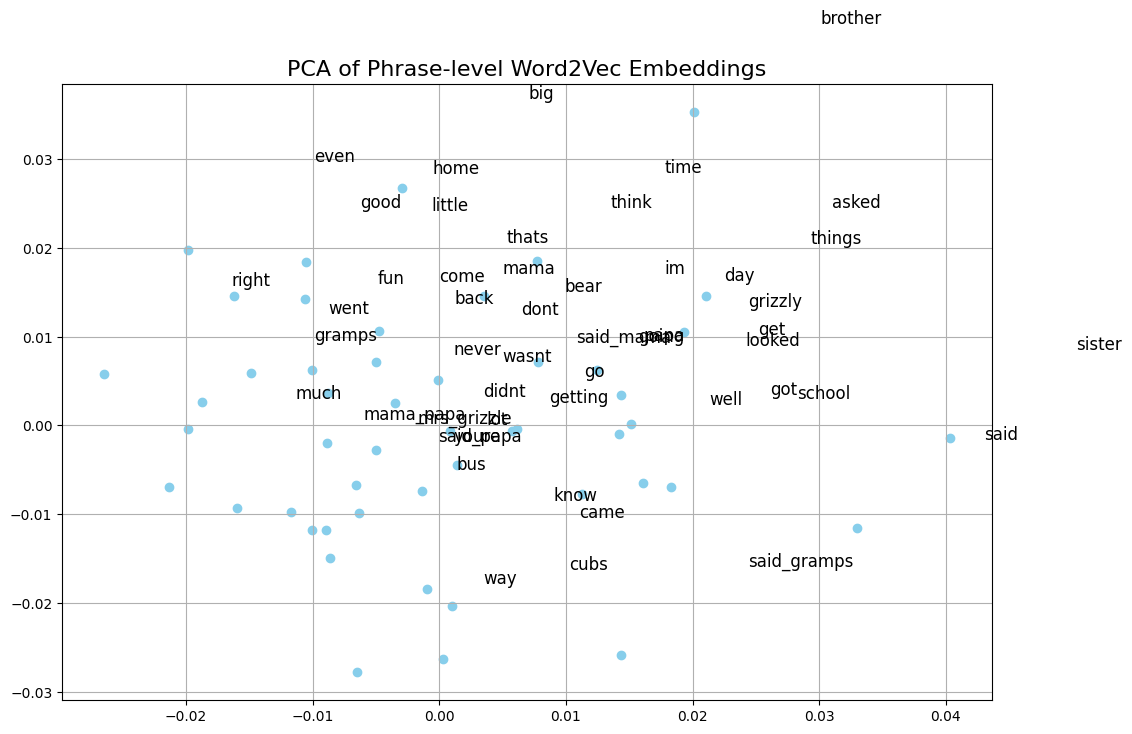

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


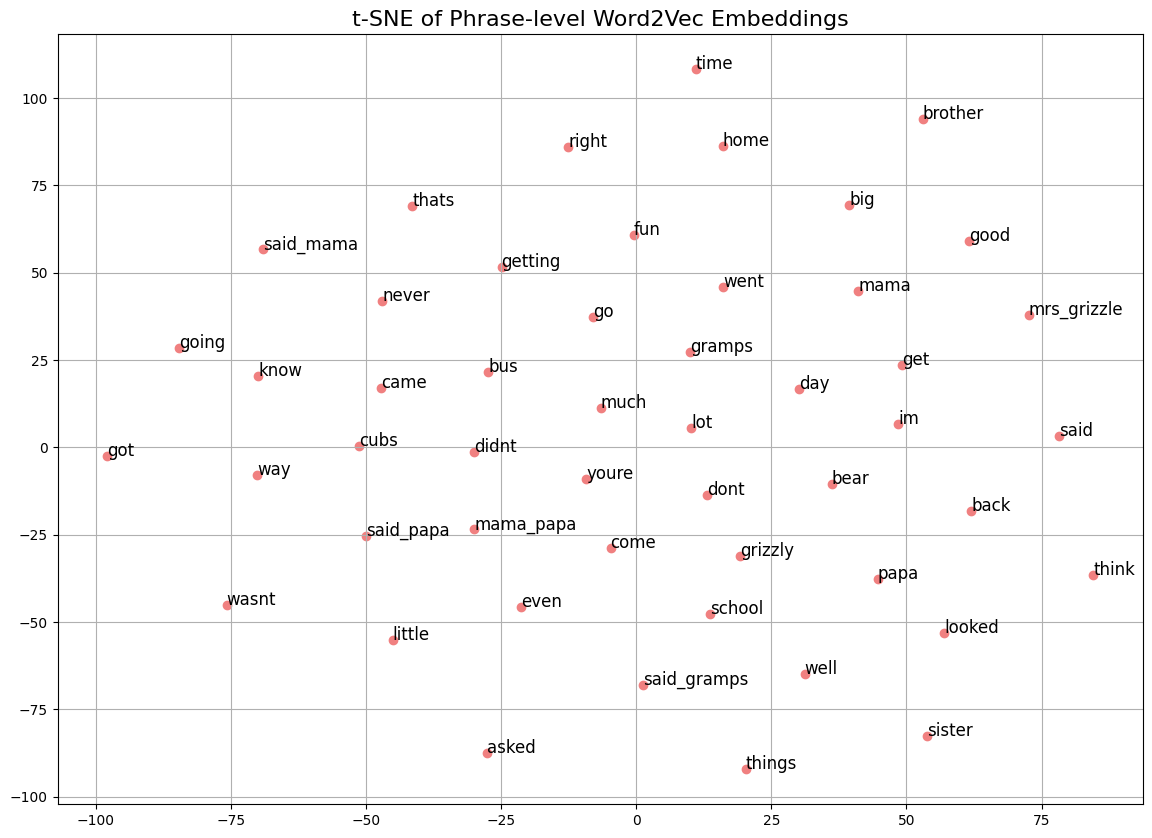

Loaded 8 text entries from 'text'.
Word2Vec model training completed.

Semantically Related Word Pairs:
said - sister: Similarity = 0.6881
said - sister: Similarity = 0.6881
said - well: Similarity = 0.6830
said - well: Similarity = 0.6830
brother - well: Similarity = 0.6806
brother - well: Similarity = 0.6806
brother - said: Similarity = 0.6787
brother - said: Similarity = 0.6787
brother - oh: Similarity = 0.6549
brother - oh: Similarity = 0.6549
brother - sister: Similarity = 0.6443
brother - sister: Similarity = 0.6443
brother - cubs: Similarity = 0.6398
brother - cubs: Similarity = 0.6398
brother - gramps: Similarity = 0.6397
came - gramps: Similarity = 0.6303
came - gramps: Similarity = 0.6303
said - wasnt: Similarity = 0.6291
said - wasnt: Similarity = 0.6291
got - said: Similarity = 0.6277
got - said: Similarity = 0.6277
gramps - said: Similarity = 0.6275
mama - sister: Similarity = 0.6251
mama - sister: Similarity = 0.6251
sister - well: Similarity = 0.6190
sister - well: Simil

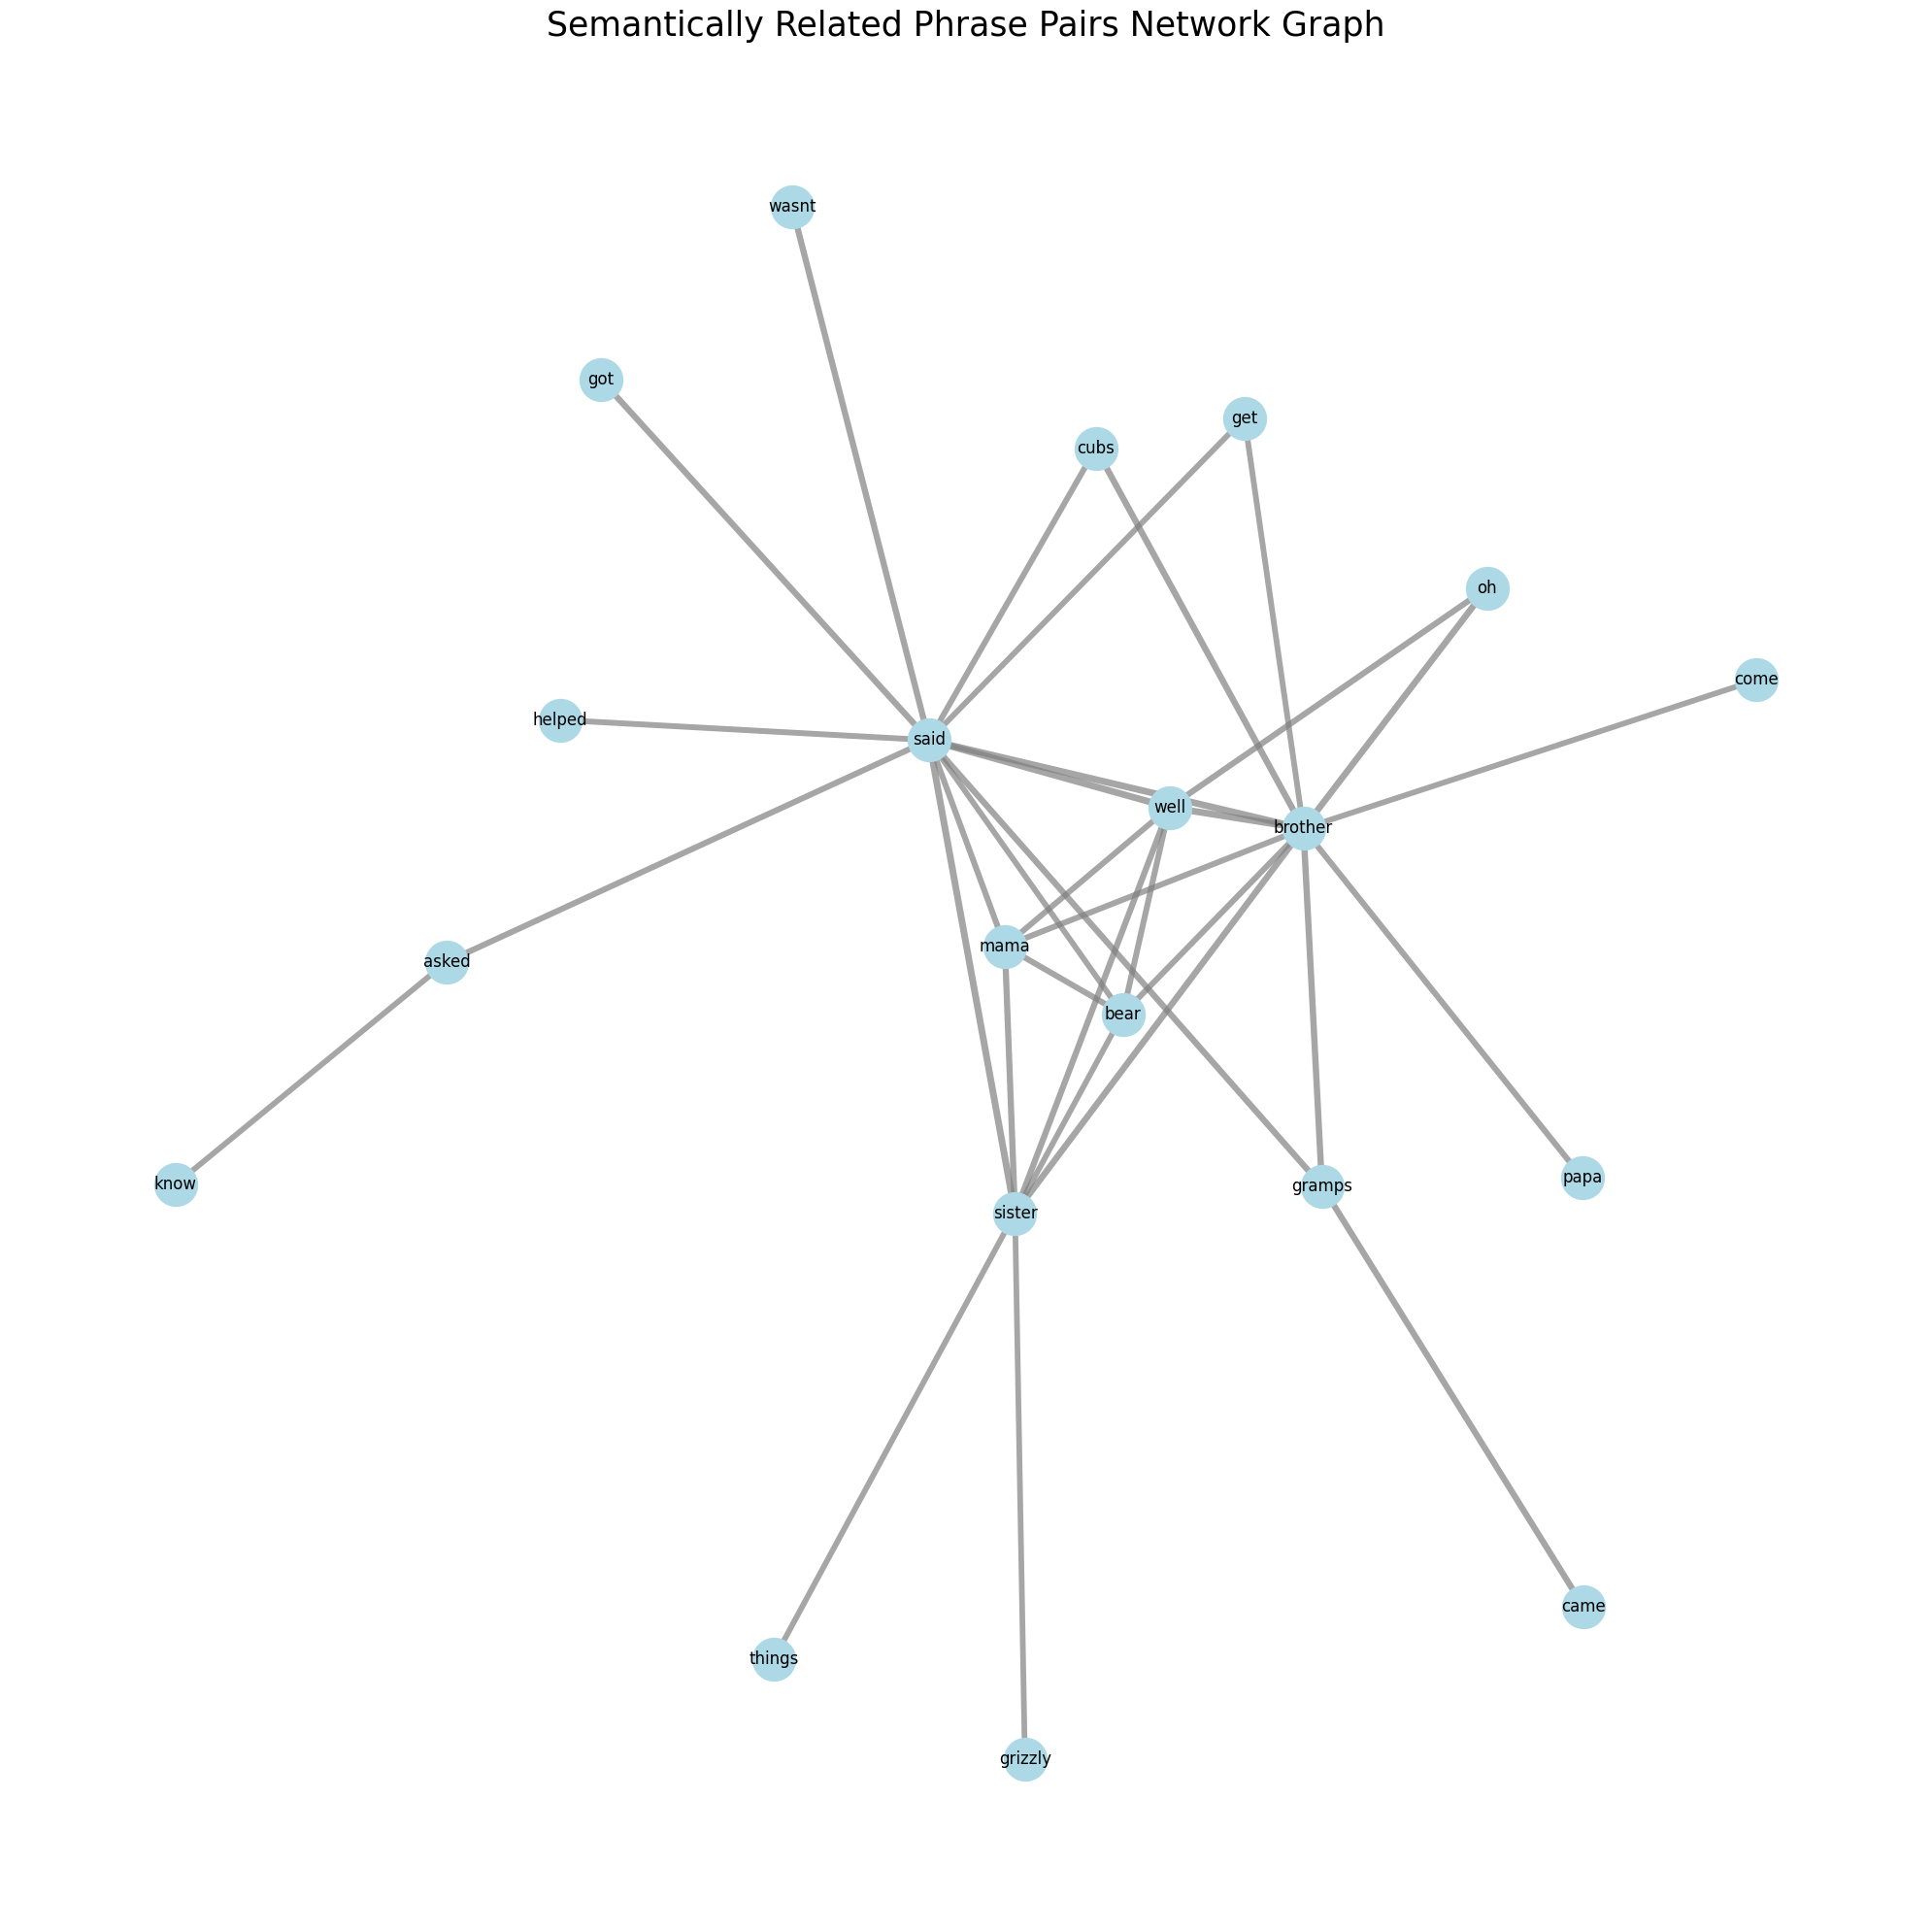

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_social.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.5,
                           save_path="/content/semantically_related_phrase_pairs_community_graph.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()






    # Step : Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_social.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.5
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_phrase_pairs_community_graph.png")

if __name__ == "__main__":
    main()

threshold of 0.6 for community narratives

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 8 text entries from 'text'.
Phrase-level Word2Vec model trained.
Top 50 semantically related phrase pairs saved.
No edges meet the similarity threshold.


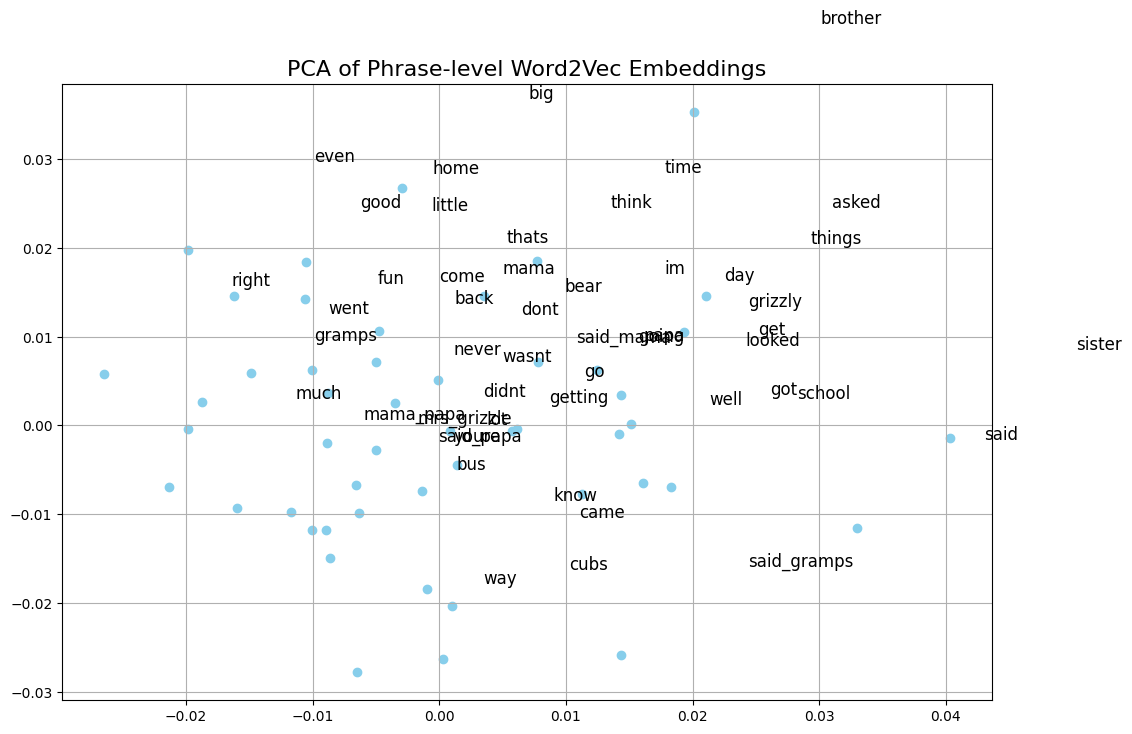

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


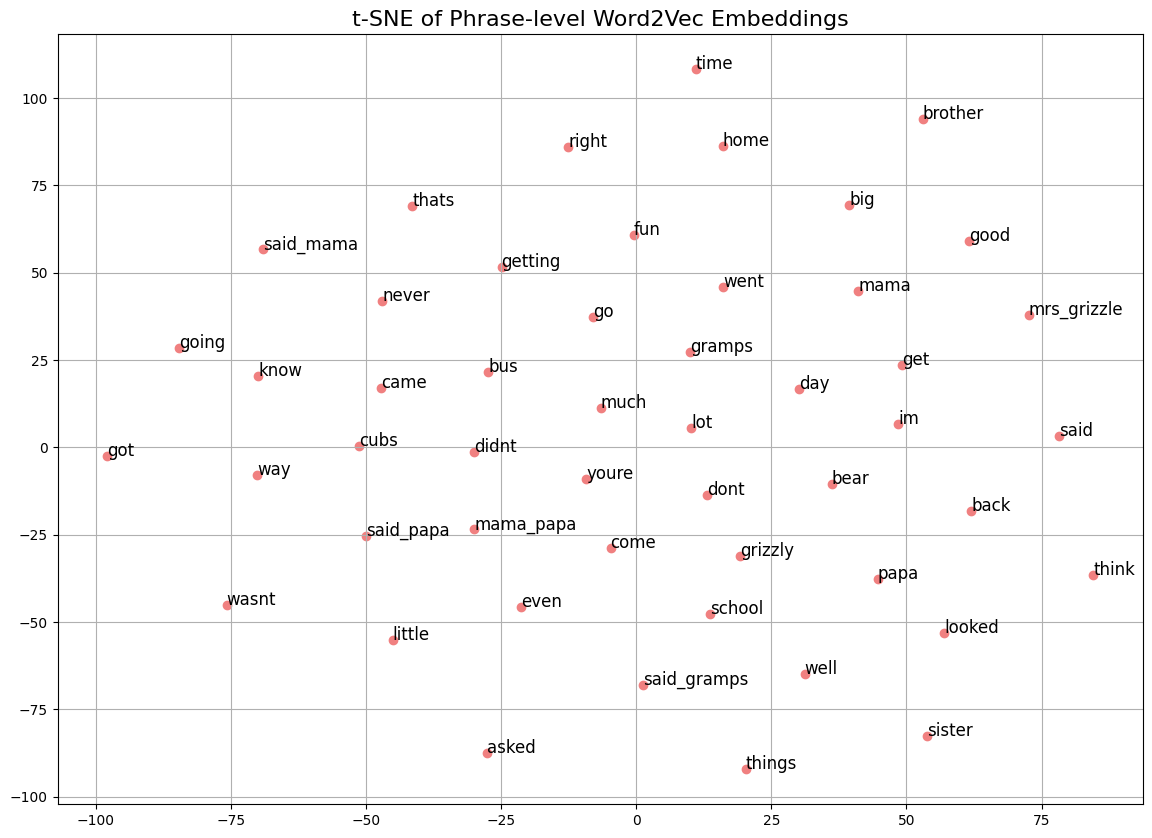

Loaded 8 text entries from 'text'.
Word2Vec model training completed.

Semantically Related Word Pairs:
said - sister: Similarity = 0.6881
said - sister: Similarity = 0.6881
said - well: Similarity = 0.6830
said - well: Similarity = 0.6830
brother - well: Similarity = 0.6806
brother - well: Similarity = 0.6806
brother - said: Similarity = 0.6787
brother - said: Similarity = 0.6787
brother - oh: Similarity = 0.6549
brother - oh: Similarity = 0.6549
brother - sister: Similarity = 0.6443
brother - sister: Similarity = 0.6443
brother - cubs: Similarity = 0.6398
brother - cubs: Similarity = 0.6398
brother - gramps: Similarity = 0.6397
came - gramps: Similarity = 0.6303
came - gramps: Similarity = 0.6303
said - wasnt: Similarity = 0.6291
said - wasnt: Similarity = 0.6291
got - said: Similarity = 0.6277
got - said: Similarity = 0.6277
gramps - said: Similarity = 0.6275
mama - sister: Similarity = 0.6251
mama - sister: Similarity = 0.6251
sister - well: Similarity = 0.6190
sister - well: Simil

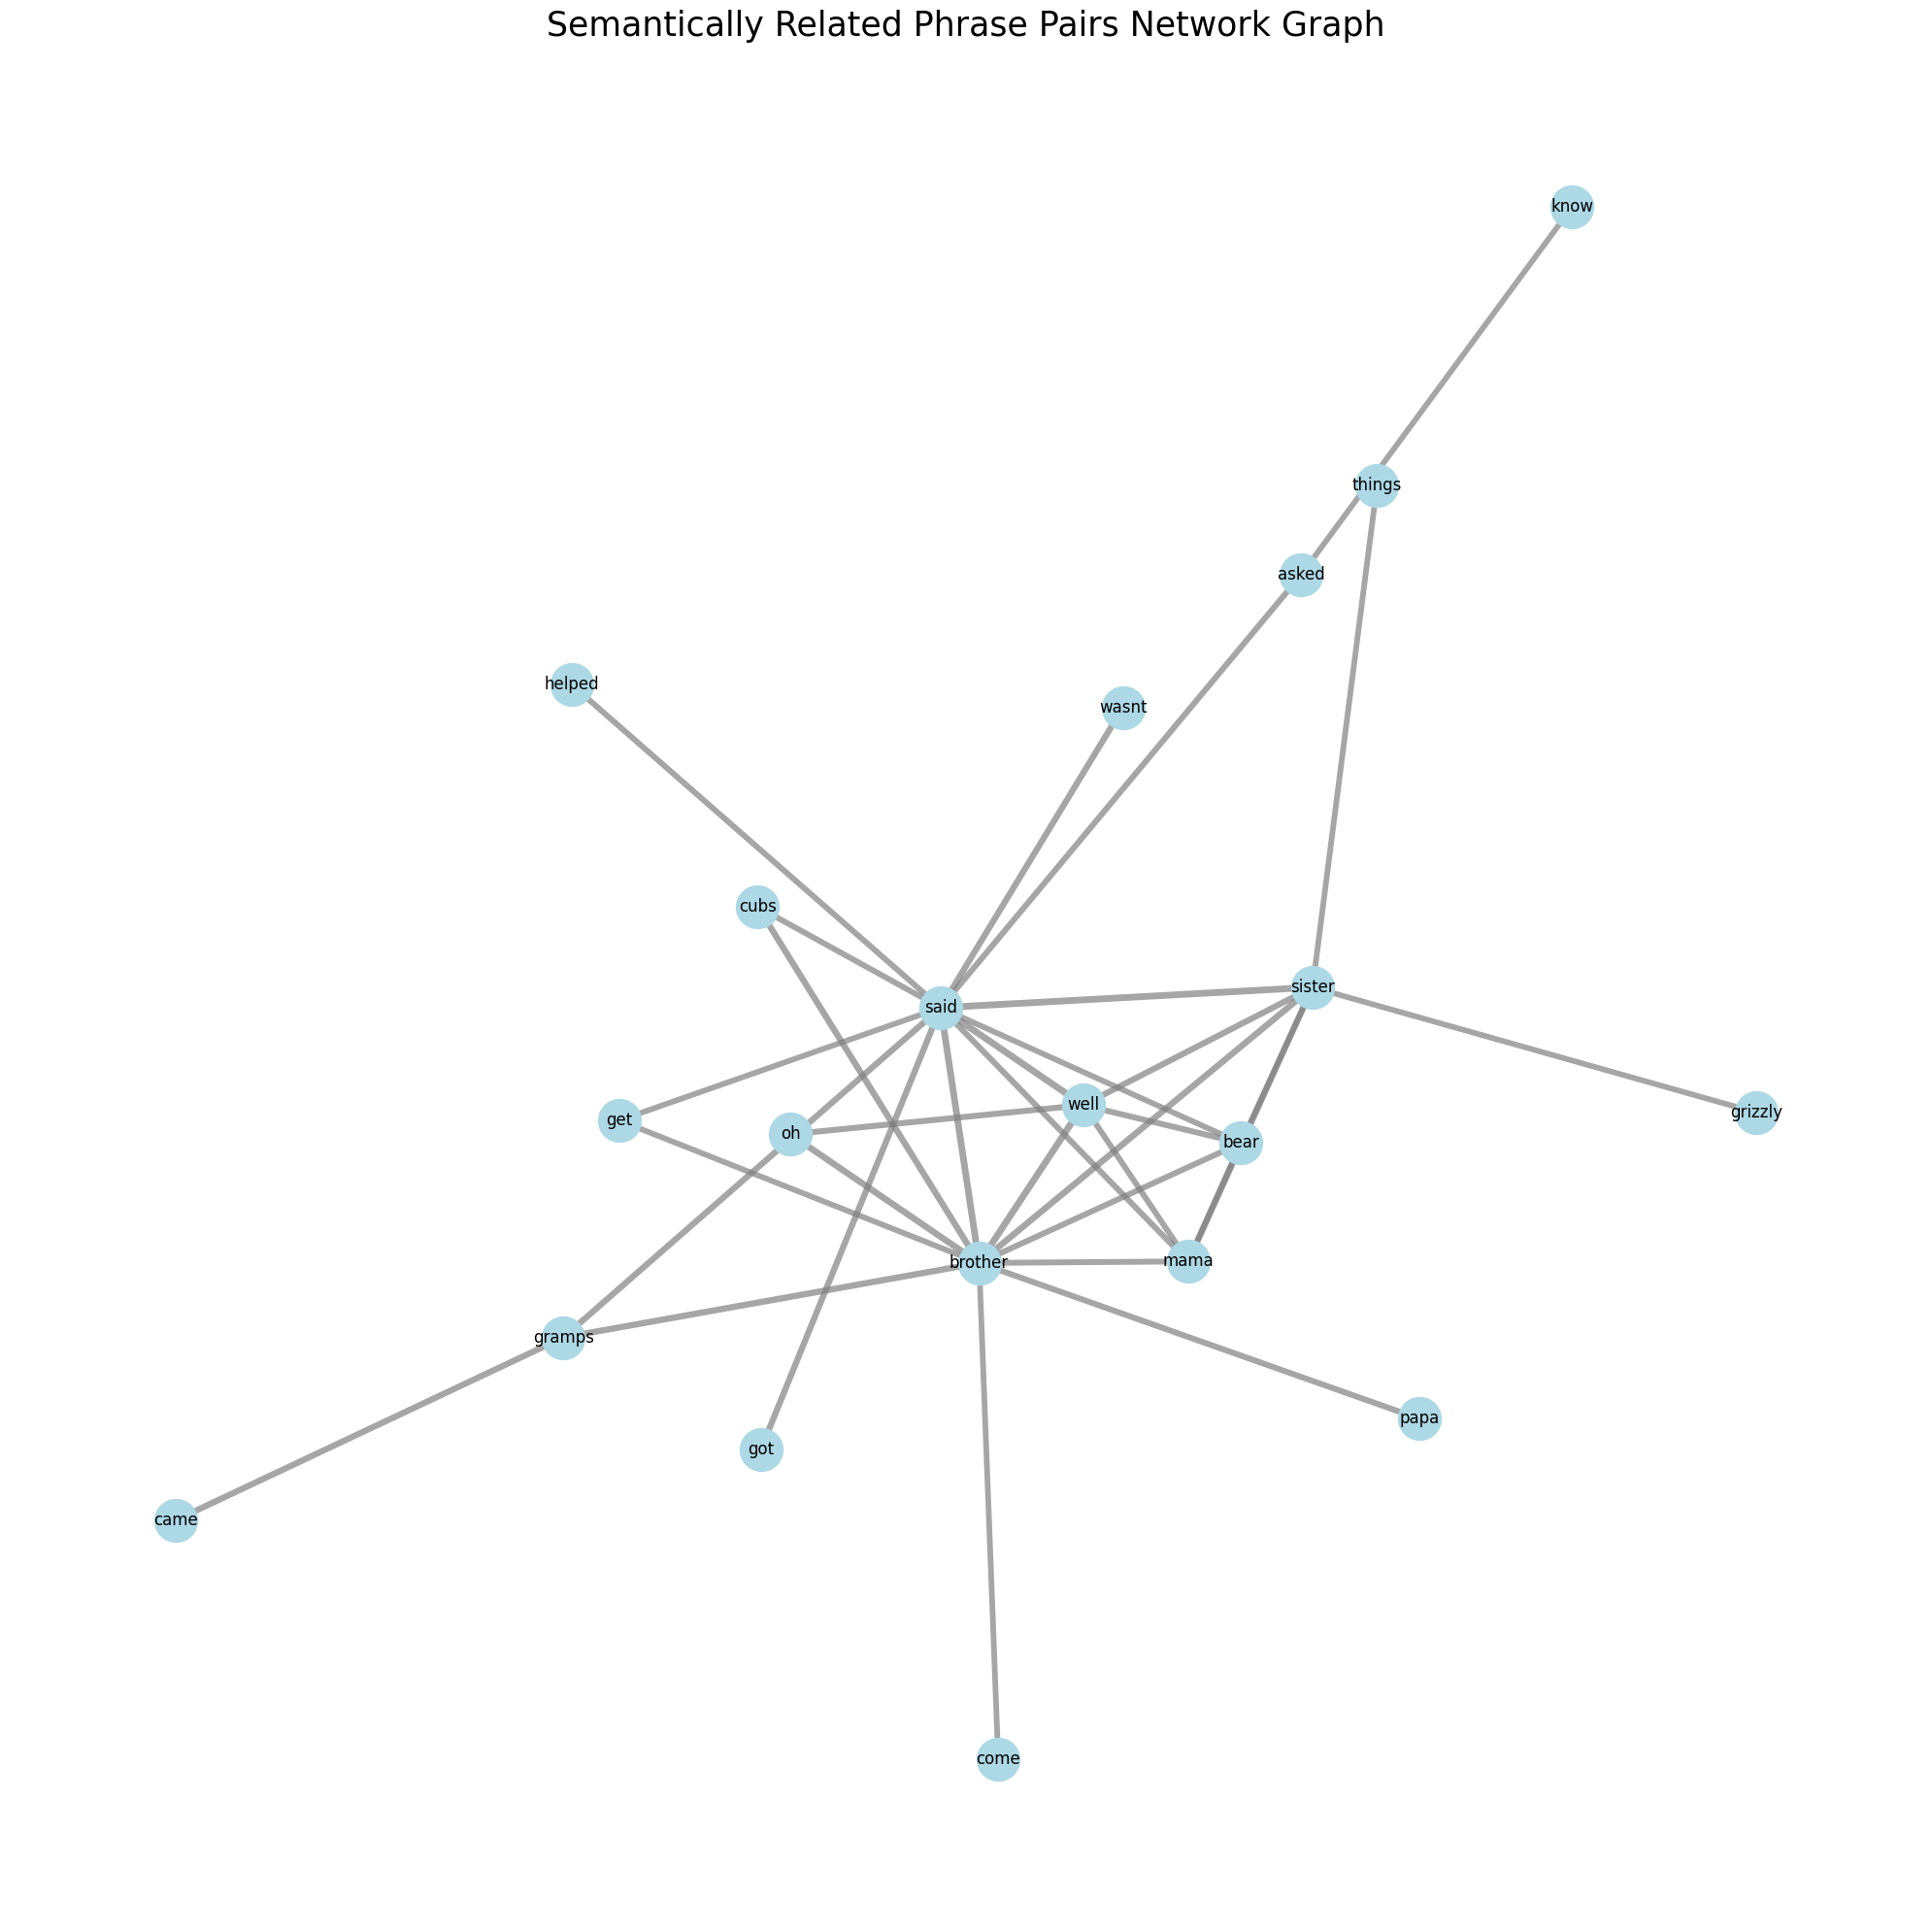

In [ ]:
# Install required packages
!pip install gensim
!pip install nltk
!pip install scikit-learn
!pip install networkx
!pip install matplotlib

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# -----------------------------
# 1. POS Mapping
# -----------------------------
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# -----------------------------
# 2. Load CSV and text column
# -----------------------------
def load_and_verify_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()
    if text_column.lower() not in df.columns:
        raise KeyError(f"Column '{text_column}' not found in CSV.")
    text_list = df[text_column.lower()].dropna().tolist()
    print(f"Loaded {len(text_list)} text entries from '{text_column}'.")
    return text_list

# -----------------------------
# 3. Preprocess text
# -----------------------------
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        filtered_tokens = [
            word for word, pos in pos_tags
            if word.isalpha() and word not in stop_words and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# -----------------------------
# 4. Phrase detection & Word2Vec
# -----------------------------
def train_phrase_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    # Detect bigrams and trigrams
    bigram = Phrases(sentences, min_count=5, threshold=10)
    trigram = Phrases(bigram[sentences], threshold=10)
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)

    # Apply phrase detection
    phrase_sentences = [trigram_phraser[bigram_phraser[sentence]] for sentence in sentences]

    # Train Word2Vec
    model = Word2Vec(phrase_sentences, vector_size=vector_size, window=window,
                     min_count=min_count, workers=workers)
    print("Phrase-level Word2Vec model trained.")
    return model, phrase_sentences

# -----------------------------
# 5. Find top semantically related phrase pairs
# -----------------------------
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)
        for sim_word, similarity in similar_words:
            sorted_pair = tuple(sorted([word, sim_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# -----------------------------
# 6. Generate network graph
# -----------------------------
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    G = nx.Graph()
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)
    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold.")
        return
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    weights = [edge_data['weight'] for _, _, edge_data in G.edges(data=True)]
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title("Semantically Related Phrase Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Graph saved to '{save_path}'")
    plt.show()

# -----------------------------
# 7. PCA and t-SNE visualization
# -----------------------------
def get_embeddings_for_visualization(model, top_n=50):
    words = list(model.wv.index_to_key)[:top_n]
    embeddings = np.array([model.wv[word] for word in words])
    return words, embeddings

def plot_pca(words, embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='skyblue')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("PCA of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

def plot_tsne(words, embeddings, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(14, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='lightcoral')
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0]+0.01, embeddings_2d[i, 1]+0.01, word, fontsize=12)
    plt.title("t-SNE of Phrase-level Word2Vec Embeddings", fontsize=16)
    plt.grid(True)
    plt.show()

# -----------------------------
# 8. Main function
# -----------------------------
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"

    text_list = load_and_verify_csv(file_path, text_column)
    sentences = preprocess_text_with_pos(text_list)

    # Train phrase-level Word2Vec
    model, phrase_sentences = train_phrase_word2vec_model(sentences)

    # Related phrase pairs
    top_n = 50
    related_pairs = find_semantically_related_pairs(model, top_n)
    df_pairs = pd.DataFrame(related_pairs, columns=['Phrase1', 'Phrase2', 'Similarity'])
    df_pairs.to_csv("/content/semantically_related_phrase_pairs_social.csv", index=False) #🍏🍏🍏🍏🍏
    print(f"Top {top_n} semantically related phrase pairs saved.")

    # Network graph
    generate_network_graph(related_pairs, similarity_threshold=0.6,
                           save_path="/content/semantically_related_phrase_pairs_community_graph.png") #🍏🍏🍏🍏🍏

    # PCA & t-SNE
    words, embeddings = get_embeddings_for_visualization(model, top_n=50)
    plot_pca(words, embeddings)
    plot_tsne(words, embeddings)

if __name__ == "__main__":
    main()






    # Step : Main Function
def main():
    file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv" #🍎🍎🍎🍎🍎
    text_column = "text"  #🍏🍏🍏🍏🍏

    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    sentences = preprocess_text_with_pos(text_list)
    model = train_word2vec_model(sentences)
    top_n = 50
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])
    output_file = "/content/semantically_related_word_pairs_social.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    print("\nGenerating network graph...")
    similarity_threshold = 0.5
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_phrase_pairs_community_graph.png")

if __name__ == "__main__":
    main()

#✅ **Polarity and Subjectivity**

In [ ]:
!pip install textblob
!pip install nltk

import pandas as pd
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Step 1: Load CSV
file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv"
text_column = "text"  # Update this if your column has a different name

try:
    df = pd.read_csv(file_path)
    print("CSV Loaded Successfully!")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print(f"File not found at '{file_path}'")

# Step 2: Initialize VADER
sid = SentimentIntensityAnalyzer()

# Step 3: Perform Sentiment Analysis
def analyze_sentiment(text):
    # TextBlob
    blob = TextBlob(text)
    tb_polarity = blob.sentiment.polarity
    tb_subjectivity = blob.sentiment.subjectivity

    # VADER
    vader_scores = sid.polarity_scores(text)

    return pd.Series({
        "TextBlob_Polarity": tb_polarity,
        "TextBlob_Subjectivity": tb_subjectivity,
        "VADER_Negative": vader_scores['neg'],
        "VADER_Neutral": vader_scores['neu'],
        "VADER_Positive": vader_scores['pos'],
        "VADER_Compound": vader_scores['compound']
    })

# Step 4: Apply sentiment analysis to the CSV column
sentiment_df = df[text_column].dropna().apply(analyze_sentiment)

# Step 5: Combine with original DataFrame
df_result = pd.concat([df, sentiment_df], axis=1)

# Step 6: Save results to CSV
output_file = "/content/BerenstainBears_SentimentResults_Family_EachVol.csv"
df_result.to_csv(output_file, index=False)
print(f"Sentiment analysis results saved to '{output_file}'")

# Optional: Preview first 5 rows
print(df_result.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CSV Loaded Successfully!
Columns: ['text', 'publish year', 'title', 'category']
Sentiment analysis results saved to '/content/BerenstainBears_SentimentResults_Family_EachVol.csv'
                                                text  publish year  \
0  Down a sunny dirt road, over a log bridge, up ...          1974   
1  The Bear family didn't always live in the big ...          1981   
2  Sister and Brother Bear at the Bear Country Li...          1982   
3  Most morning, in Bear Country, the sun rose to...          1982   
4  It was a lazy sort of day in Bear Country. The...          1983   

            title   category  TextBlob_Polarity  TextBlob_Subjectivity  \
0        new baby    family            0.017036               0.423618   
1      moving day   family             0.179499               0.569566   
2     in the dark   family             0.054489               0.522520   
3  get in a fight    family            0.109134               0.433849   
4       the truth  family     

In [ ]:
!pip install textblob
!pip install nltk

import pandas as pd
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Step 1: Load CSV
file_path = "/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv"
text_column = "text"  # Update this if your column has a different name

try:
    df = pd.read_csv(file_path)
    print("CSV Loaded Successfully!")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print(f"File not found at '{file_path}'")

# Step 2: Initialize VADER
sid = SentimentIntensityAnalyzer()

# Step 3: Perform Sentiment Analysis
def analyze_sentiment(text):
    # TextBlob
    blob = TextBlob(text)
    tb_polarity = blob.sentiment.polarity
    tb_subjectivity = blob.sentiment.subjectivity

    # VADER
    vader_scores = sid.polarity_scores(text)

    return pd.Series({
        "TextBlob_Polarity": tb_polarity,
        "TextBlob_Subjectivity": tb_subjectivity,
        "VADER_Negative": vader_scores['neg'],
        "VADER_Neutral": vader_scores['neu'],
        "VADER_Positive": vader_scores['pos'],
        "VADER_Compound": vader_scores['compound']
    })

# Step 4: Apply sentiment analysis to the CSV column
sentiment_df = df[text_column].dropna().apply(analyze_sentiment)

# Step 5: Combine with original DataFrame
df_result = pd.concat([df, sentiment_df], axis=1)

# Step 6: Save results to CSV
output_file = "/content/BerenstainBears_SentimentResults_Community_EachVol.csv"
df_result.to_csv(output_file, index=False)
print(f"Sentiment analysis results saved to '{output_file}'")

# Optional: Preview first 5 rows
print(df_result.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CSV Loaded Successfully!
Columns: ['text', 'publish year', 'title', 'category']
Sentiment analysis results saved to '/content/BerenstainBears_SentimentResults_Community_EachVol.csv'
                                                text  publish year  \
0  It was a notice telling about an important mee...          1981   
1  It was the last day of school and the beginnin...          1982   
2  The Bear family, who lived in the big tree hou...          1984   
3  Brother and Sister Bear, who lived with their ...          1985   
4  On the way to school one day Sister Bear, Brot...          1986   

                   title   category  TextBlob_Polarity  TextBlob_Subjectivity  \
0                 sitter    social            0.254975               0.500455   
1             go to camp   social             0.201646               0.474228   
2         mama's new job  social              0.312625               0.625624   
3  learn about strangers  social              0.047678               0.52

Sentiment analysis for Family Narratives

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    down a sunny dirt road over a log bridge up a ...
1    they lived in a large tree which papa bear had...
2                             it was a very fine house
3                   this is what it looked like inside
4    it was fun growing up in bear countryhelping p...
Name: text, dtype: object
* Negative Flag:  129
* Neutral Flag:  277
* Positive Flag:  217
Total:  623


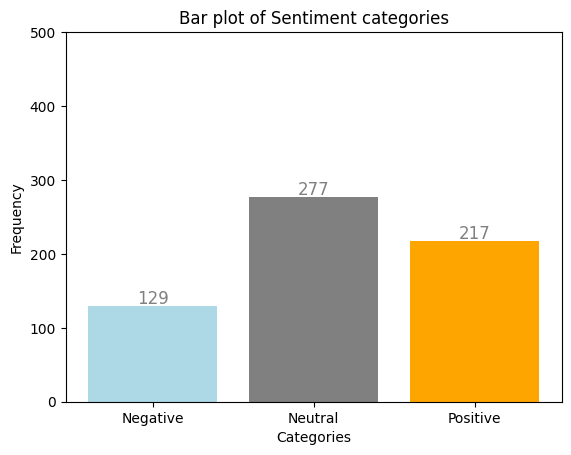

In [ ]:
#🐹 🐾 For full-fleged version of sentiment analysis can be found github.com/ms624atyale/BerenstainBears_4Research/35_SentimentAnalysisip_AesopFables_Final.ipynb



#필요한 라이브러리(VADER library) 불러오기
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

#successfully working code lines. Use this and ignore the othere.
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Read your CSV file with a single 'text' column
df = pd.read_csv('/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8family.csv')  # Replace 'your_csv_file.csv' with the actual file path

# Tokenize the text by sentences and create a new DataFrame
dfsentiment = df['text'].apply(sent_tokenize).explode().reset_index(drop=True)

# Clean punctuation and convert to lowercase
dfsentiment = dfsentiment.apply(remove_punctuations).str.lower()

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Custom function to calculate the compound score for each sentence
def calculate_compound_score(sentence):
    sentiment_scores = sid.polarity_scores(sentence)
    return sentiment_scores['compound']

# Calculate the compound score for each sentence
dfsentiment['CompScore'] = dfsentiment.apply(calculate_compound_score)

# Adding Sentiment Flags
dfsentiment['PosFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment['NegFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment['NeuFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if -0.05 < x < 0.05 else 0)

# Display the modified DataFrame
print(dfsentiment.head())

dfsentiment.head(20)


#[1] 감정분석 결과 막대그래프 (부정, 중립, 긍정)

print('* Negative Flag: ', dfsentiment['NegFlag'].sum())
print('* Neutral Flag: ', dfsentiment['NeuFlag'].sum())
print('* Positive Flag: ', dfsentiment['PosFlag'].sum())
print("="*50)
print('Total: ',dfsentiment['PosFlag'].sum()+dfsentiment['NeuFlag'].sum()+dfsentiment['NegFlag'].sum())


import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment['NegFlag'].sum())
Neutral = int(dfsentiment['NeuFlag'].sum())
Positive = int(dfsentiment['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]
# freqs = [18385, 33544, 19055]

# Create labels for the bars
labels = ['Negative', 'Neutral', 'Positive']

# Create x coordinates for the bars
x = np.arange(len(labels))

# Generate the bar plot
plt.bar(x, freqs)


# Specify the colors for each category
colors = ['lightblue', 'gray', 'orange']

# Generate the bar plot with custom colors

bars = plt.bar(x, freqs, color=colors)
# Add labels to the x-axis
plt.xticks(x, labels)

# Set axis labels
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Bar plot of Sentiment categories')
plt.ylim(0, 500)
# Add the frequency text within each bar
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2, str(freq),
             ha='center', va='bottom', fontsize=12, color='gray')


# Display the plot
plt.show()

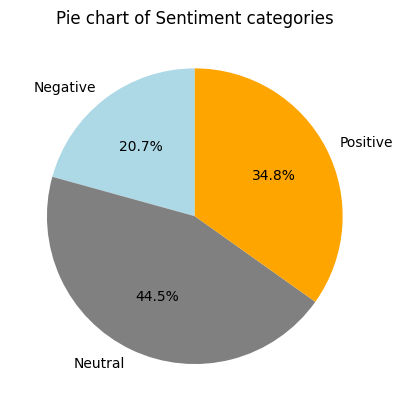

In [ ]:
# 감정분석 카테고리 파이차트 (비율확인용)
import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment['NegFlag'].sum())
Neutral = int(dfsentiment['NeuFlag'].sum())
Positive = int(dfsentiment['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]

# Create labels for the segments
labels = ['Negative', 'Neutral', 'Positive']

# Specify the colors for each segment
colors = ['lightblue', 'gray', 'orange']

# Generate the pie chart with custom colors
plt.pie(freqs, labels=labels, colors=colors, autopct='%.1f%%', startangle=90)

# Set a title for the plot
plt.title('Pie chart of Sentiment categories')

# Display the plot
plt.show()

Sentiment analysis for Community Narratives

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    it was a notice telling about an important mee...
1    whats this said papa bear as he took the days ...
2    it was a notice telling about an important mee...
3                     mama bear called up grizzly gran
4    brother and sister bear sometimes stayed with ...
Name: text, dtype: object
* Negative Flag:  111
* Neutral Flag:  331
* Positive Flag:  283
Total:  725


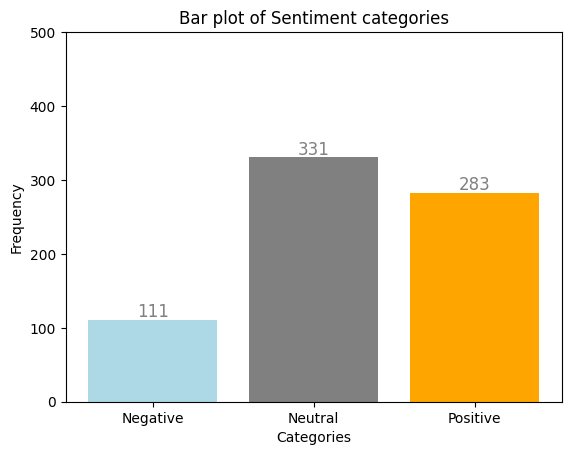

In [ ]:
#🐹 🐾 For full-fleged version of sentiment analysis can be found github.com/ms624atyale/BerenstainBears_4Research/35_SentimentAnalysisip_AesopFables_Final.ipynb



#필요한 라이브러리(VADER library) 불러오기
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

#successfully working code lines. Use this and ignore the othere.
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Read your CSV file with a single 'text' column
df = pd.read_csv('/content/Berenstain_FamilySocial/Data_Sentiment_Blesch_Frame/berenstain_8social.csv')  # Replace 'your_csv_file.csv' with the actual file path

# Tokenize the text by sentences and create a new DataFrame
dfsentiment = df['text'].apply(sent_tokenize).explode().reset_index(drop=True)

# Clean punctuation and convert to lowercase
dfsentiment = dfsentiment.apply(remove_punctuations).str.lower()

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Custom function to calculate the compound score for each sentence
def calculate_compound_score(sentence):
    sentiment_scores = sid.polarity_scores(sentence)
    return sentiment_scores['compound']

# Calculate the compound score for each sentence
dfsentiment['CompScore'] = dfsentiment.apply(calculate_compound_score)

# Adding Sentiment Flags
dfsentiment['PosFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment['NegFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment['NeuFlag'] = dfsentiment['CompScore'].apply(lambda x: 1 if -0.05 < x < 0.05 else 0)

# Display the modified DataFrame
print(dfsentiment.head())

dfsentiment.head(20)


#[1] 감정분석 결과 막대그래프 (부정, 중립, 긍정)

print('* Negative Flag: ', dfsentiment['NegFlag'].sum())
print('* Neutral Flag: ', dfsentiment['NeuFlag'].sum())
print('* Positive Flag: ', dfsentiment['PosFlag'].sum())
print("="*50)
print('Total: ',dfsentiment['PosFlag'].sum()+dfsentiment['NeuFlag'].sum()+dfsentiment['NegFlag'].sum())


import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment['NegFlag'].sum())
Neutral = int(dfsentiment['NeuFlag'].sum())
Positive = int(dfsentiment['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]
# freqs = [18385, 33544, 19055]

# Create labels for the bars
labels = ['Negative', 'Neutral', 'Positive']

# Create x coordinates for the bars
x = np.arange(len(labels))

# Generate the bar plot
plt.bar(x, freqs)


# Specify the colors for each category
colors = ['lightblue', 'gray', 'orange']

# Generate the bar plot with custom colors

bars = plt.bar(x, freqs, color=colors)
# Add labels to the x-axis
plt.xticks(x, labels)

# Set axis labels
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Bar plot of Sentiment categories')
plt.ylim(0, 500)
# Add the frequency text within each bar
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2, str(freq),
             ha='center', va='bottom', fontsize=12, color='gray')


# Display the plot
plt.show()

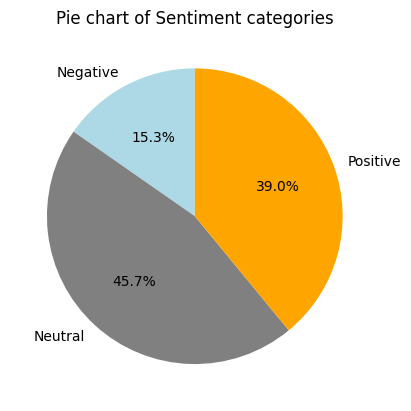

In [ ]:
# 감정분석 카테고리 파이차트 (비율확인용)
import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment['NegFlag'].sum())
Neutral = int(dfsentiment['NeuFlag'].sum())
Positive = int(dfsentiment['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]

# Create labels for the segments
labels = ['Negative', 'Neutral', 'Positive']

# Specify the colors for each segment
colors = ['lightblue', 'gray', 'orange']

# Generate the pie chart with custom colors
plt.pie(freqs, labels=labels, colors=colors, autopct='%.1f%%', startangle=90)

# Set a title for the plot
plt.title('Pie chart of Sentiment categories')

# Display the plot
plt.show()